In [89]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/european-soccer-data/Full_Dataset.csv
/kaggle/input/big-five-european-soccer-leagues/BIG FIVE 1995-2019.csv
/kaggle/input/fifa-players-ratings/fifa_cleaned.csv


Define the Datasets

*Here three datasets have been downloaded. The first is a dataset from the big five European soccer leagues from the 1995-2019 seasons. The second is the from the same 5 leagues from the years 2002/03-2022/23. The last is a dataset recording statistics from 11 countries during the 2008-2016 seasons. Let's create dataframes for each file. I'll also print the first one here:*

In [90]:
df1 = pd.read_csv('/kaggle/input/big-five-european-soccer-leagues/BIG FIVE 1995-2019.csv') 
df2 = pd.read_csv('/kaggle/input/european-soccer-data/Full_Dataset.csv')
df3 = pd.read_csv('/kaggle/input/fifa-players-ratings/fifa_cleaned.csv')


print(df1.iloc[44012])


Round                                38
Date            (Sun) 26 May 2019 (W21)
Team 1                       Torino FC 
FT                                  3-1
HT                                  0-0
Team 2                        SS Lazio 
Year                               2018
Country                              IT
FT Team 1                             3
FT Team 2                             1
HT Team 1                             0
HT Team 2                             0
GGD                                   2
Team 1 (pts)                          3
Team 2 (pts)                          0
Name: 44012, dtype: object


These column names look very interesting. Let me look at the second dataframe since it has similar data, and decide which columns I want to add or subtract. For now I want to keep everything except "Team 1" and "Team 2", since I'd rather know who is the home team and who is the away team.

In [91]:
print(df2.iloc[0])

Round                       ROUND 1
Date                     31/08/2002
Time                          22:30
Team               RACING SANTANDER
Team_Score                      0.0
Opponent_Score                  1.0
Opponent                 VALLADOLID
Home_Score_AET                  NaN
Away_Score_AET                  NaN
Home_Penalties                  NaN
Away_Penalties                  NaN
Team_Points                     0.0
Opponent_Points                 3.0
season                         2002
Location                       Home
Country                       spain
Competition        primera-division
Name: 0, dtype: object


*So this dataset has location, which we'll keep. I'll use location to update all of the 'Team 1' and 'Team 2' things in df1. Everything else doesn't really matter since we already have it, but we can keep the AET and Penalties columns just in case. Now, I'll read the third dataset:*

In [92]:
print(df3.columns)

Index(['id', 'name', 'full_name', 'birth_date', 'age', 'height_cm',
       'weight_kgs', 'positions', 'nationality', 'overall_rating', 'potential',
       'value_euro', 'wage_euro', 'preferred_foot',
       'international_reputation(1-5)', 'weak_foot(1-5)', 'skill_moves(1-5)',
       'work_rate', 'body_type', 'release_clause_euro', 'club_team',
       'club_rating', 'club_position', 'club_jersey_number', 'club_join_date',
       'contract_end_year', 'national_team', 'national_rating',
       'national_team_position', 'national_jersey_number', 'crossing',
       'finishing', 'heading_accuracy', 'short_passing', 'volleys',
       'dribbling', 'curve', 'freekick_accuracy', 'long_passing',
       'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions',
       'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots',
       'aggression', 'interceptions', 'positioning', 'vision', 'penalties',
       'composure', 'marking', 'standing_tackle', 'sliding_tackle',
  

*A lot of the columns here are unnecessary, but there are a few I want to keep as part of the modeling I do. I'll need to work backwards and figure out the year date for this since it doesn't have it. So I'll keep 'name,' 'birth_date,' 'age,' 'positions,' 'nationality,' 'overall_rating,' 'club_team,' 'club_rating,' 'national_team,' 'national_rating,' and 'contract_end_year' for my analysis. I'll also need to switch around the rows and columns.*

*So now since I know all the information these dataframes hold, I need to do a couple things. First, I need to identify the home and away teams in df1. Next, I need to trim the unnecessary information from df1 and df2 and combine the rest. After that, I need to switch around the rows and columns for df3. Then I can do some EDA.*

*To identify the home teams, I need to trim by year first. Not only do I have to match the start date, but df1 goes until the 2019-20 season, which was cut short by COVID-19. The first date in the dataset for df2 starts on the date 2002-08-31, so we'll do from 08/01/2002 to 08/01/2019.*

In [93]:
# Convert 'Date' to datetime format with a custom format
df1['Date'] = pd.to_datetime(df1['Date'], format='(%a) %d %b %Y (W%U)')

# Specify the start and end dates
start_date_2002_03 = pd.to_datetime('2002-08-17')
end_date_2002_03 = pd.to_datetime('2019-08-01')  # Adjust the end date as needed

# Filter rows where the date is within the specified range
df1_filtered = df1[(df1['Date'] >= start_date_2002_03) & (df1['Date'] <= end_date_2002_03)]

# Display the filtered DataFrame
print(df1_filtered)



       Round       Date                     Team 1   FT   HT  \
2660       1 2002-08-24       Blackburn Rovers FC   0-0  0-0   
2661       1 2002-08-24      Charlton Athletic FC   2-3  2-1   
2662       1 2002-08-24                Everton FC   2-2  1-0   
2663       1 2002-08-24                 Fulham FC   4-1  3-1   
2664       1 2002-08-24           Leeds United FC   3-0  2-0   
...      ...        ...                        ...  ...  ...   
44008     38 2019-05-26  FC Internazionale Milano   2-1  0-0   
44009     38 2019-05-26                   AS Roma   2-1  1-0   
44010     38 2019-05-26              UC Sampdoria   2-0  0-0   
44011     38 2019-05-26                      SPAL   2-3  1-2   
44012     38 2019-05-26                 Torino FC   3-1  0-0   

                      Team 2  Year Country  FT Team 1  FT Team 2  HT Team 1  \
2660         Sunderland AFC   2002     ENG          0          0          0   
2661             Chelsea FC   2002     ENG          2          3         

*Now, I'll drop columns from df2 and use it to edit df1.*

In [94]:
columns_to_drop = ['Round', 'Time', 'Team_Score', 'Opponent_Score', 'Opponent_Points']

# Drop specified columns
df2 = df2.drop(columns=columns_to_drop)

# Convert 'Date' to datetime format with a custom format
df2['Date'] = pd.to_datetime(df2['Date'], format='%d/%m/%Y')

# Specify the start and end dates
start_date_2002_03 = pd.to_datetime('2002-08-17')
end_date_2002_03 = pd.to_datetime('2019-08-01')  # Adjust the end date as needed

# Filter rows where the date is within the specified range
df2 = df2[(df2['Date'] >= start_date_2002_03) & (df2['Date'] <= end_date_2002_03)]

# Display the modified DataFrame
print(df2)



             Date              Team         Opponent  Home_Score_AET  \
0      2002-08-31  RACING SANTANDER       VALLADOLID             NaN   
1      2002-09-01    RAYO VALLECANO           ALAVES             NaN   
2      2002-09-01     REAL SOCIEDAD  ATHLETIC BILBAO             NaN   
3      2002-09-01          MALLORCA         VALENCIA             NaN   
4      2002-09-01        VILLARREAL          OSASUNA             NaN   
...           ...               ...              ...             ...   
106622 2019-02-26          AC MILAN            LAZIO             NaN   
106623 2019-02-27          ATALANTA       FIORENTINA             NaN   
106624 2019-04-24             LAZIO         AC MILAN             NaN   
106625 2019-04-25        FIORENTINA         ATALANTA             NaN   
106626 2019-05-15             LAZIO         ATALANTA             NaN   

        Away_Score_AET  Home_Penalties  Away_Penalties  Team_Points  season  \
0                  NaN             NaN             NaN  

In [95]:
#Use df2 to figure out which team is Home and Away
print(df2.iloc[20])

print(df1.iloc[12251])

print(df2.iloc[30])

print(df1.iloc[12263])

import pandas as pd
df2['Date'] = pd.to_datetime(df2['Date'], format='%d/%m/%Y')

# Specify the date range and team
date1 = pd.to_datetime('2002-08-01')
date2 = pd.to_datetime('2002-09-28')
target_team = 'BARCELONA'  # Replace with the actual team name

# Filter rows based on date range and team
filtered_rows = df2[(df2['Date'] >= date1) & (df2['Date'] <= date2) & (df2['Team'] == target_team)]

# Display the filtered DataFrame
print(filtered_rows)


Date              2002-09-21 00:00:00
Team                        BARCELONA
Opponent                     ESPANYOL
Home_Score_AET                    NaN
Away_Score_AET                    NaN
Home_Penalties                    NaN
Away_Penalties                    NaN
Team_Points                       3.0
season                           2002
Location                         Home
Country                         spain
Competition          primera-division
Name: 20, dtype: object
Round                             2
Date            2002-09-28 00:00:00
Team 1                FC Barcelona 
FT                              2-0
HT                              0-0
Team 2                RCD Espanyol 
Year                           2002
Country                         ESP
FT Team 1                         2
FT Team 2                         0
HT Team 1                         0
HT Team 2                         0
GGD                               2
Team 1 (pts)                      3
Team 2 (pts)    

*After a long, inefficient process, I was able to find the column in df1 that matched df2. However, since df2 is indexed by team and has the location column, the score columns are not done by scoreline. Usually, a score puts the home team on one side and the away team on another, but this is not the case in this dataset. I looked up Real Madrid's 2002-03 schedule since there's would certainly be available, and found that their game against Valladolid on 09/28/2002 was a home game. Then, I checked Barcelona, but this is also not true in this case. Since I want to use HT and FT scores for my model, I'm instead going to combine df1 to df2.*

In [96]:
import pandas as pd

# Assuming df1 and df2 are your DataFrames
# Convert 'Date' columns to a common format
df1_filtered['Date'] = pd.to_datetime(df1_filtered['Date'], format=' %d %m %Y (W%U)')
df2['Date'] = pd.to_datetime(df2['Date'], format='%d %m %Y (W%U)')

columns_to_keep = ['Date', 'Team 1', 'Team 2', 'FT', 'HT']  


merged_df = pd.merge(df1_filtered[columns_to_keep], df2, how='outer', left_on=['Date', 'Team 1', 'Team 2'], right_on=['Date', 'Team', 'Opponent'])

# Filter out rows where there is no match on the specified columns
merged_df = merged_df.dropna(subset=['Date', 'Team', 'Opponent'])

# Combine 'HT' and 'FT' columns from df1_filtered where NaN in merged_df
merged_df['HT'] = merged_df['HT'].combine_first(df1_filtered['HT'])
merged_df['FT'] = merged_df['FT'].combine_first(df1_filtered['FT'])

# Drop columns with NaN values
merged_df = merged_df.dropna(axis=1, how='all')


# Display the merged DataFrame without duplicates
print(merged_df)

/tmp/ipykernel_42/3818995952.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_filtered['Date'] = pd.to_datetime(df1_filtered['Date'], format=' %d %m %Y (W%U)')


             Date   FT   HT              Team         Opponent  \
30879  2002-08-31  2-1  2-1  RACING SANTANDER       VALLADOLID   
30880  2002-09-01  1-1  0-0    RAYO VALLECANO           ALAVES   
30881  2002-09-01  0-6  0-3     REAL SOCIEDAD  ATHLETIC BILBAO   
30882  2002-09-01  0-2  0-1          MALLORCA         VALENCIA   
30883  2002-09-01  6-0  1-0        VILLARREAL          OSASUNA   
...           ...  ...  ...               ...              ...   
116478 2019-02-26  NaN  NaN          AC MILAN            LAZIO   
116479 2019-02-27  NaN  NaN          ATALANTA       FIORENTINA   
116480 2019-04-24  NaN  NaN             LAZIO         AC MILAN   
116481 2019-04-25  NaN  NaN        FIORENTINA         ATALANTA   
116482 2019-05-15  NaN  NaN             LAZIO         ATALANTA   

        Home_Score_AET  Away_Score_AET  Home_Penalties  Away_Penalties  \
30879              NaN             NaN             NaN             NaN   
30880              NaN             NaN             NaN     

In [97]:
# Create new columns 'Team_Score', 'Opponent_Score', 'Team_Halftime_Score', and 'Opponent_Halftime_Score'
merged_df['Team_Score'] = merged_df['FT'].apply(lambda x: int(x.split('-')[0]) if pd.notna(x) else None)
merged_df['Opponent_Score'] = merged_df['FT'].apply(lambda x: int(x.split('-')[1]) if pd.notna(x) else None)
merged_df['Team_Halftime_Score'] = merged_df['HT'].apply(lambda x: int(x.split('-')[0]) if pd.notna(x) else None)
merged_df['Opponent_Halftime_Score'] = merged_df['HT'].apply(lambda x: int(x.split('-')[1]) if pd.notna(x) else None)

# Display the modified merged DataFrame
print(merged_df[['Date', 'Team', 'Opponent', 'Location', 'Team_Halftime_Score', 'Opponent_Halftime_Score', 'Team_Score', 'Opponent_Score', 'Home_Score_AET', 'Away_Score_AET', 'Home_Penalties', 'Away_Penalties']])

             Date              Team         Opponent Location  \
30879  2002-08-31  RACING SANTANDER       VALLADOLID     Home   
30880  2002-09-01    RAYO VALLECANO           ALAVES     Home   
30881  2002-09-01     REAL SOCIEDAD  ATHLETIC BILBAO     Home   
30882  2002-09-01          MALLORCA         VALENCIA     Home   
30883  2002-09-01        VILLARREAL          OSASUNA     Home   
...           ...               ...              ...      ...   
116478 2019-02-26          AC MILAN            LAZIO     Away   
116479 2019-02-27          ATALANTA       FIORENTINA     Away   
116480 2019-04-24             LAZIO         AC MILAN     Away   
116481 2019-04-25        FIORENTINA         ATALANTA     Away   
116482 2019-05-15             LAZIO         ATALANTA     Away   

        Team_Halftime_Score  Opponent_Halftime_Score  Team_Score  \
30879                   2.0                      1.0         2.0   
30880                   0.0                      0.0         1.0   
30881          

*This looks a lot closer to the data I want. However, there are still a couple of things I want to add. For instance, what about goal differential at HT and FT? This might be more useful because it can measure a team likelihood of winning a game vs drawing or losing while not biasing teams who win by scoring a lot or who win a lot of low-scoring contests. I'm going to add a couple columns for that.*

In [98]:
merged_df['Goal_Differential_HT'] = merged_df['Team_Halftime_Score'] - merged_df['Opponent_Halftime_Score']
merged_df['Goal_Differential_FT'] = merged_df['Team_Score'] - merged_df['Opponent_Score']

print(merged_df)

             Date   FT   HT              Team         Opponent  \
30879  2002-08-31  2-1  2-1  RACING SANTANDER       VALLADOLID   
30880  2002-09-01  1-1  0-0    RAYO VALLECANO           ALAVES   
30881  2002-09-01  0-6  0-3     REAL SOCIEDAD  ATHLETIC BILBAO   
30882  2002-09-01  0-2  0-1          MALLORCA         VALENCIA   
30883  2002-09-01  6-0  1-0        VILLARREAL          OSASUNA   
...           ...  ...  ...               ...              ...   
116478 2019-02-26  NaN  NaN          AC MILAN            LAZIO   
116479 2019-02-27  NaN  NaN          ATALANTA       FIORENTINA   
116480 2019-04-24  NaN  NaN             LAZIO         AC MILAN   
116481 2019-04-25  NaN  NaN        FIORENTINA         ATALANTA   
116482 2019-05-15  NaN  NaN             LAZIO         ATALANTA   

        Home_Score_AET  Away_Score_AET  Home_Penalties  Away_Penalties  \
30879              NaN             NaN             NaN             NaN   
30880              NaN             NaN             NaN     

*Great! This looks like everything I want for now. We'll mostly be using merged_df moving forward. Now, I'm gonna start thinking about how to actually measure my question. Since this is about using data to find the best teams, I'll start with some EDA and then go from there.*

*The first thing that came to mind is to find the mean and mode for points in each season in each league, as well as average goal differential. What this will do is tell me generally how an average team would perform.*

In [99]:
merged_df.describe()

,Date,Home_Score_AET,Away_Score_AET,Home_Penalties,Away_Penalties,Team_Points,season,Team_Score,Opponent_Score,Team_Halftime_Score,Opponent_Halftime_Score,Goal_Differential_HT,Goal_Differential_FT
count,85604,2392.000000,2392.000000,1144.000000,1144.000000,85598.000000,85604.000000,10768.000000,10768.000000,10768.000000,10768.000000,10768.000000,10768.000000
mean,2011-04-05 02:47:14.446988288,1.449833,1.377090,3.762238,3.910839,1.384098,2010.268469,1.555256,1.181278,0.690193,0.507058,0.183135,0.373978
min,2002-08-17 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,2002.000000,0.000000,0.000000,0.000000,0.000000,-5.000000,-7.000000
25%,2007-01-30 00:00:00,1.000000,1.000000,3.000000,3.000000,0.000000,2006.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
50%,2011-04-17 00:00:00,1.000000,1.000000,4.000000,4.000000,1.000000,2010.000000,1.000000,1.000000,0.500000,0.000000,0.000000,0.000000
75%,2015-05-10 00:00:00,2.000000,2.000000,5.000000,5.000000,3.000000,2014.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000
max,2019-06-01 00:00:00,8.000000,6.000000,13.000000,14.000000,3.000000,2018.000000,9.000000,8.000000,6.000000,5.000000,5.000000,8.000000
std,NaN,1.159757,1.094044,1.738688,1.715787,1.331532,4.836729,1.276384,1.130730,0.830956,0.709072,1.098090,1.729475


*Above shows the summary statistics for the entire dataframe.*

In [100]:
# Drop everything that has an NaN value
merged_df = merged_df.dropna(subset=['Team_Score', 'Opponent_Score'])

# Display the cleaned DataFrame
print(merged_df)


            Date   FT   HT              Team         Opponent  Home_Score_AET  \
30879 2002-08-31  2-1  2-1  RACING SANTANDER       VALLADOLID             NaN   
30880 2002-09-01  1-1  0-0    RAYO VALLECANO           ALAVES             NaN   
30881 2002-09-01  0-6  0-3     REAL SOCIEDAD  ATHLETIC BILBAO             NaN   
30882 2002-09-01  0-2  0-1          MALLORCA         VALENCIA             NaN   
30883 2002-09-01  6-0  1-0        VILLARREAL          OSASUNA             NaN   
...          ...  ...  ...               ...              ...             ...   
44008 2003-01-01  2-1  0-0    MANCHESTER UTD       SUNDERLAND             NaN   
44009 2003-01-01  2-1  1-0             LEEDS       BIRMINGHAM             NaN   
44010 2003-01-01  2-0  0-0       SOUTHAMPTON        TOTTENHAM             NaN   
44011 2003-01-01  2-3  1-2       ASTON VILLA           BOLTON             NaN   
44012 2003-01-01  3-1  0-0         BLACKBURN    MIDDLESBROUGH             NaN   

       Away_Score_AET  Home

In [101]:
merged_df['season'] = merged_df['season'].astype(str)
merged_df['Competition'] = merged_df['Competition'].astype(str)

# Exclude NaN values for specific columns within each competition
columns_to_exclude_nan = ['Team_Score', 'Opponent_Score', 'Goal_Differential_FT']

# Custom aggregation function for mean and mode excluding NaN values
def custom_agg_no_nan(series):
    non_nan_values = series.dropna()  # or series[series.notna()] for a more explicit check
    return {
        'mean': '{:.2f}'.format(non_nan_values.mean()),
    }

# Calculate mean and mode for points in each season in each league excluding NaN values
mean_points_no_nan = merged_df.groupby(['season', 'Competition'])[columns_to_exclude_nan].agg(custom_agg_no_nan).reset_index()

# Display the results with mean rounded to two decimal points, excluding NaN values
print("Mean Points (excluding NaN values):")
print(mean_points_no_nan)

Mean Points (excluding NaN values):
    season       Competition        Team_Score    Opponent_Score  \
0   2002.0    premier-league  {'mean': '1.47'}  {'mean': '1.21'}   
1   2002.0  primera-division  {'mean': '1.62'}  {'mean': '1.20'}   
2   2003.0  primera-division  {'mean': '1.51'}  {'mean': '1.16'}   
3   2004.0  primera-division  {'mean': '1.57'}  {'mean': '1.15'}   
4   2005.0  primera-division  {'mean': '1.54'}  {'mean': '1.16'}   
5   2006.0  primera-division  {'mean': '1.53'}  {'mean': '1.23'}   
6   2007.0  primera-division  {'mean': '1.60'}  {'mean': '1.12'}   
7   2008.0  primera-division  {'mean': '1.58'}  {'mean': '1.16'}   
8   2009.0  primera-division  {'mean': '1.58'}  {'mean': '1.25'}   
9   2010.0  primera-division  {'mean': '1.52'}  {'mean': '1.11'}   
10  2011.0  primera-division  {'mean': '1.56'}  {'mean': '1.14'}   
11  2012.0  primera-division  {'mean': '1.57'}  {'mean': '1.21'}   
12  2013.0  primera-division  {'mean': '1.63'}  {'mean': '1.26'}   
13  2014.0  

*I had to make a really tough choice and delete everything that had an NaN value in the score, so I can actually go forward with this (Cries in Chelsea fan). That leaves me with only the Spanish first division data and one Premier League season, which I'm going to delete.*

In [102]:

merged_df = merged_df[~((merged_df['Team_Score'].isna()) | (merged_df['Opponent_Score'].isna()))]

# Exclude rows where the competition is 'premier-league'
merged_df = merged_df[merged_df['Competition'] != 'premier-league']

#Redefine mean Score
mean_points_no_nan = merged_df.groupby(['season', 'Competition'])[columns_to_exclude_nan].agg(custom_agg_no_nan).reset_index()

# Display the results with mean rounded to two decimal points, excluding NaN values
print("Mean Score (excluding NaN values):")
print(mean_points_no_nan)

Mean Score (excluding NaN values):
    season       Competition        Team_Score    Opponent_Score  \
0   2002.0  primera-division  {'mean': '1.62'}  {'mean': '1.20'}   
1   2003.0  primera-division  {'mean': '1.51'}  {'mean': '1.16'}   
2   2004.0  primera-division  {'mean': '1.57'}  {'mean': '1.15'}   
3   2005.0  primera-division  {'mean': '1.54'}  {'mean': '1.16'}   
4   2006.0  primera-division  {'mean': '1.53'}  {'mean': '1.23'}   
5   2007.0  primera-division  {'mean': '1.60'}  {'mean': '1.12'}   
6   2008.0  primera-division  {'mean': '1.58'}  {'mean': '1.16'}   
7   2009.0  primera-division  {'mean': '1.58'}  {'mean': '1.25'}   
8   2010.0  primera-division  {'mean': '1.52'}  {'mean': '1.11'}   
9   2011.0  primera-division  {'mean': '1.56'}  {'mean': '1.14'}   
10  2012.0  primera-division  {'mean': '1.57'}  {'mean': '1.21'}   
11  2013.0  primera-division  {'mean': '1.63'}  {'mean': '1.26'}   
12  2014.0  primera-division  {'mean': '1.46'}  {'mean': '1.17'}   
13  2015.0  p

*Now we have some solid data to plot, so I'll go ahead and do so.*

In [103]:
import matplotlib.pyplot as plt

# Create a DataFrame
primera = mean_points_no_nan

print(primera)

    season       Competition        Team_Score    Opponent_Score  \
0   2002.0  primera-division  {'mean': '1.62'}  {'mean': '1.20'}   
1   2003.0  primera-division  {'mean': '1.51'}  {'mean': '1.16'}   
2   2004.0  primera-division  {'mean': '1.57'}  {'mean': '1.15'}   
3   2005.0  primera-division  {'mean': '1.54'}  {'mean': '1.16'}   
4   2006.0  primera-division  {'mean': '1.53'}  {'mean': '1.23'}   
5   2007.0  primera-division  {'mean': '1.60'}  {'mean': '1.12'}   
6   2008.0  primera-division  {'mean': '1.58'}  {'mean': '1.16'}   
7   2009.0  primera-division  {'mean': '1.58'}  {'mean': '1.25'}   
8   2010.0  primera-division  {'mean': '1.52'}  {'mean': '1.11'}   
9   2011.0  primera-division  {'mean': '1.56'}  {'mean': '1.14'}   
10  2012.0  primera-division  {'mean': '1.57'}  {'mean': '1.21'}   
11  2013.0  primera-division  {'mean': '1.63'}  {'mean': '1.26'}   
12  2014.0  primera-division  {'mean': '1.46'}  {'mean': '1.17'}   
13  2015.0  primera-division  {'mean': '1.54'}  

In [104]:
# Extract numerical values from dictionaries
primera['Team_Score'] = primera['Team_Score'].apply(lambda x: x['mean'])
primera['Opponent_Score'] = primera['Opponent_Score'].apply(lambda x: x['mean'])
primera['Goal_Differential_FT'] = primera['Goal_Differential_FT'].apply(lambda x: x['mean'])

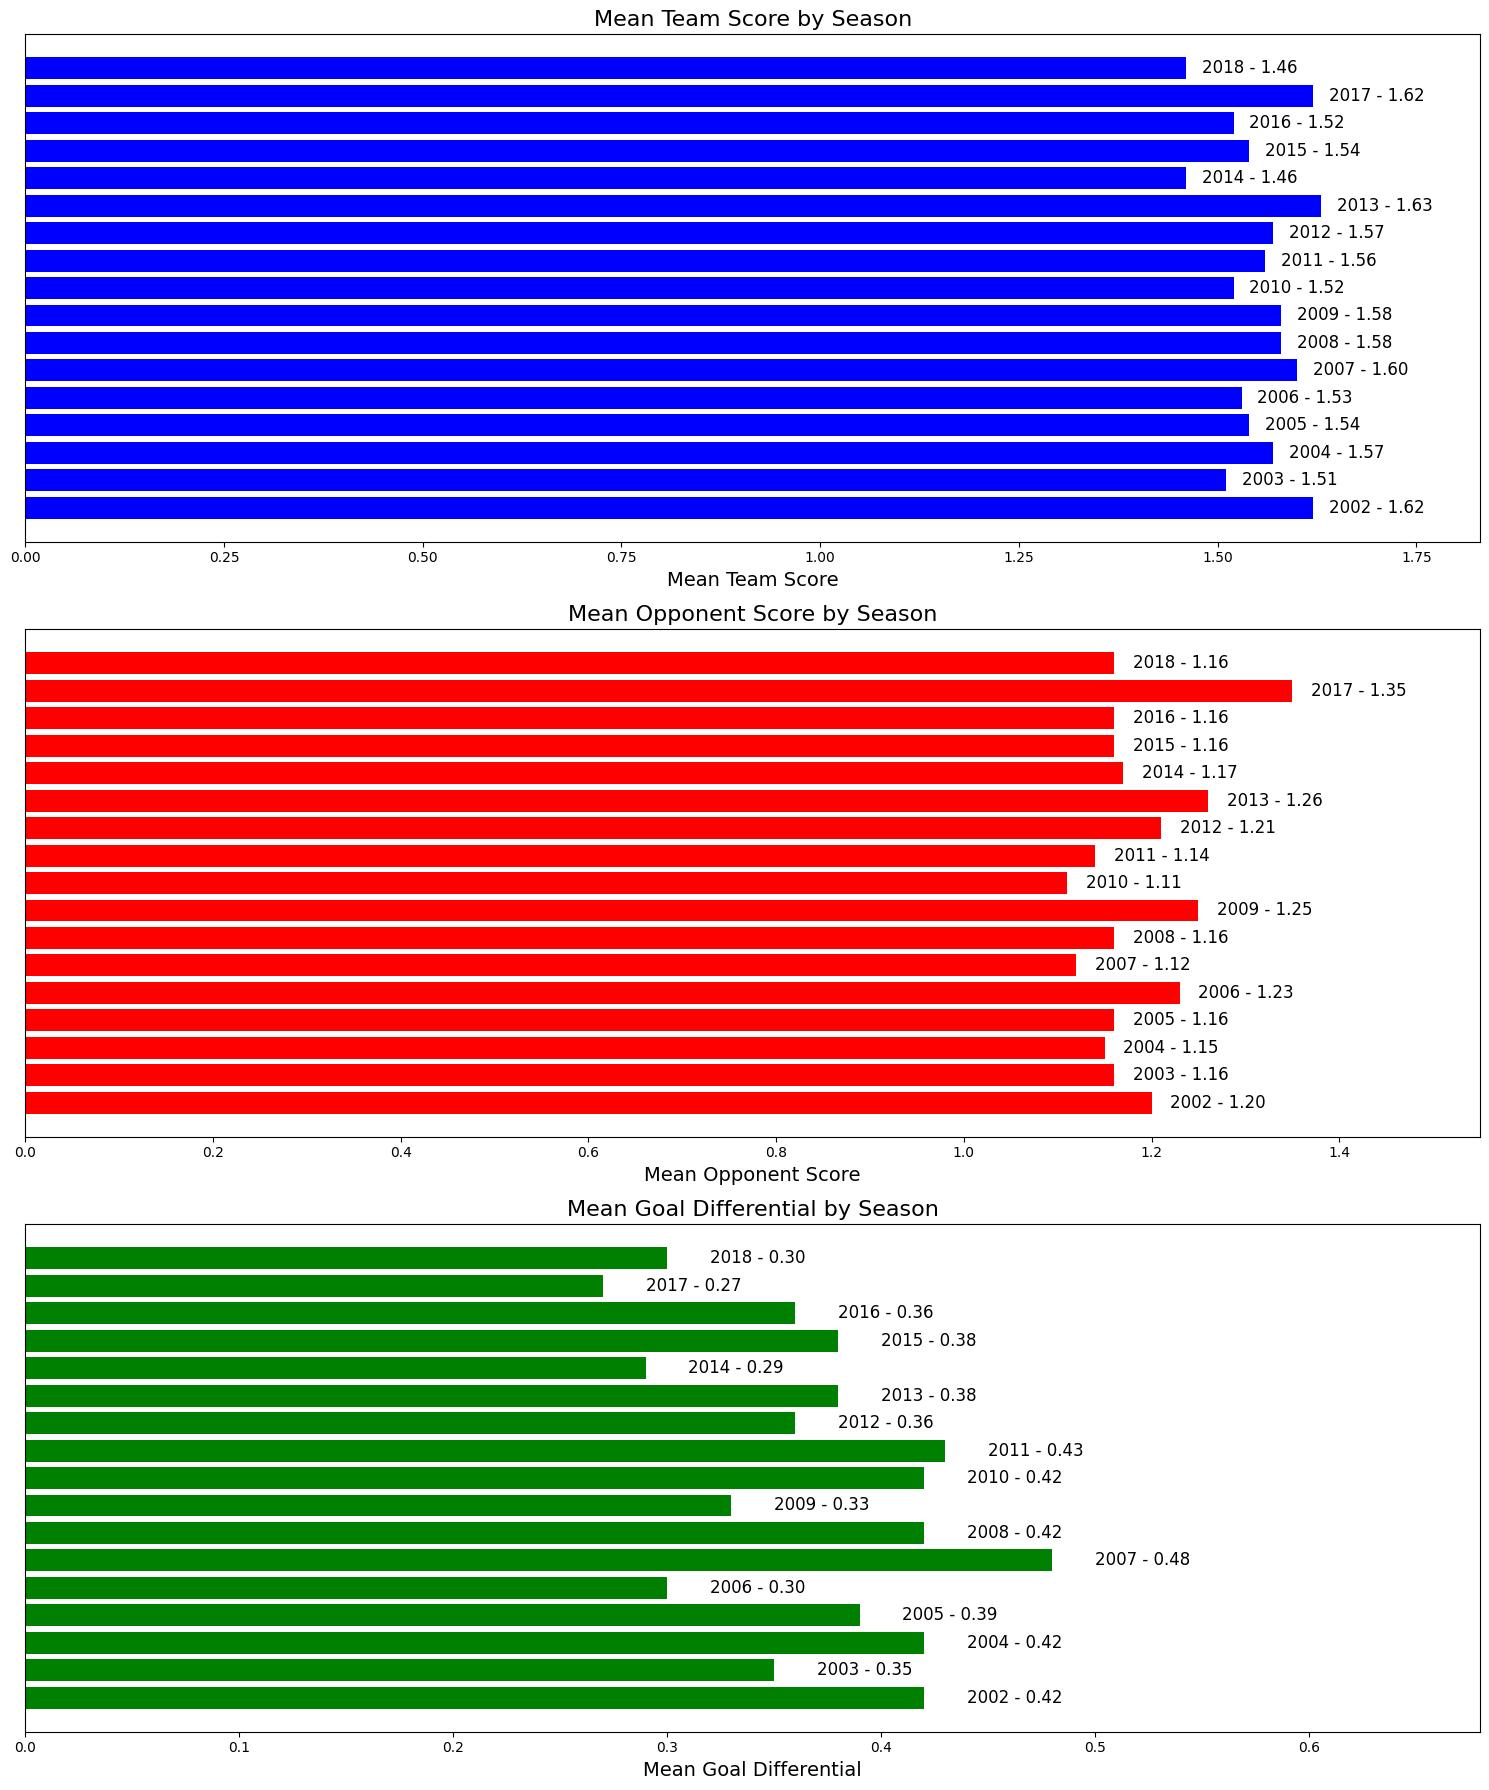

In [105]:
import numpy as np
import matplotlib.pyplot as plt

# I remade the primera data because it wasn't running properly
seasons = np.array([2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018])
mean_team_score = np.array([1.62, 1.51, 1.57, 1.54, 1.53, 1.60, 1.58, 1.58, 1.52, 1.56, 1.57, 1.63, 1.46, 1.54, 1.52, 1.62, 1.46])
mean_opponent_score = np.array([1.20, 1.16, 1.15, 1.16, 1.23, 1.12, 1.16, 1.25, 1.11, 1.14, 1.21, 1.26, 1.17, 1.16, 1.16, 1.35, 1.16])
mean_goal_differential = np.array([0.42, 0.35, 0.42, 0.39, 0.30, 0.48, 0.42, 0.33, 0.42, 0.43, 0.36, 0.38, 0.29, 0.38, 0.36, 0.27, 0.30])

# Sort data by year
sorted_indices = np.argsort(seasons)

# Create subplots with separate axes
fig, axs = plt.subplots(3, 1, figsize=(15, 18))

# Team Score
axs[0].barh(seasons[sorted_indices], mean_team_score[sorted_indices], color='blue')
axs[0].set_title('Mean Team Score by Season', fontsize=16)
axs[0].set_xlabel('Mean Team Score', fontsize=14)
axs[0].set_yticks([])  # Remove y-axis tick marks
axs[0].set_xlim(0, max(mean_team_score) + 0.2)  # Set x-axis limits

for i, (year, value) in enumerate(zip(seasons[sorted_indices], mean_team_score[sorted_indices])):
    axs[0].text(value + 0.02, year, f'{year} - {value:.2f}', va='center', ha='left', fontsize=12)

# Opponent Score
axs[1].barh(seasons[sorted_indices], mean_opponent_score[sorted_indices], color='red')
axs[1].set_title('Mean Opponent Score by Season', fontsize=16)
axs[1].set_xlabel('Mean Opponent Score', fontsize=14)
axs[1].set_yticks([])  # Remove y-axis tick marks
axs[1].set_xlim(0, max(mean_opponent_score) + 0.2)  # Set x-axis limits

for i, (year, value) in enumerate(zip(seasons[sorted_indices], mean_opponent_score[sorted_indices])):
    axs[1].text(value + 0.02, year, f'{year} - {value:.2f}', va='center', ha='left', fontsize=12)

# Goal Differential
axs[2].barh(seasons[sorted_indices], mean_goal_differential[sorted_indices], color='green')
axs[2].set_title('Mean Goal Differential by Season', fontsize=16)
axs[2].set_xlabel('Mean Goal Differential', fontsize=14)
axs[2].set_yticks([])  # Remove y-axis tick marks
axs[2].set_xlim(0, max(mean_goal_differential) + 0.2)  # Set x-axis limits

for i, (year, value) in enumerate(zip(seasons[sorted_indices], mean_goal_differential[sorted_indices])):
    axs[2].text(value + 0.02, year, f'{year} - {value:.2f}', va='center', ha='left', fontsize=12)

plt.tight_layout()
plt.show()


*The data clearly doesn't show much of a trend for any of the scoring statistics measured. So, essentially how much a team scores or doesn't score doesn't necessarily matter, at least not as shown here. Maybe I'll take a look at the average goals scored (and allowed) for wins, draws, and losses, and see how much of a difference there is.*

season            float64
Team_Points       float64
Team_Score        float64
Opponent_Score    float64
dtype: object


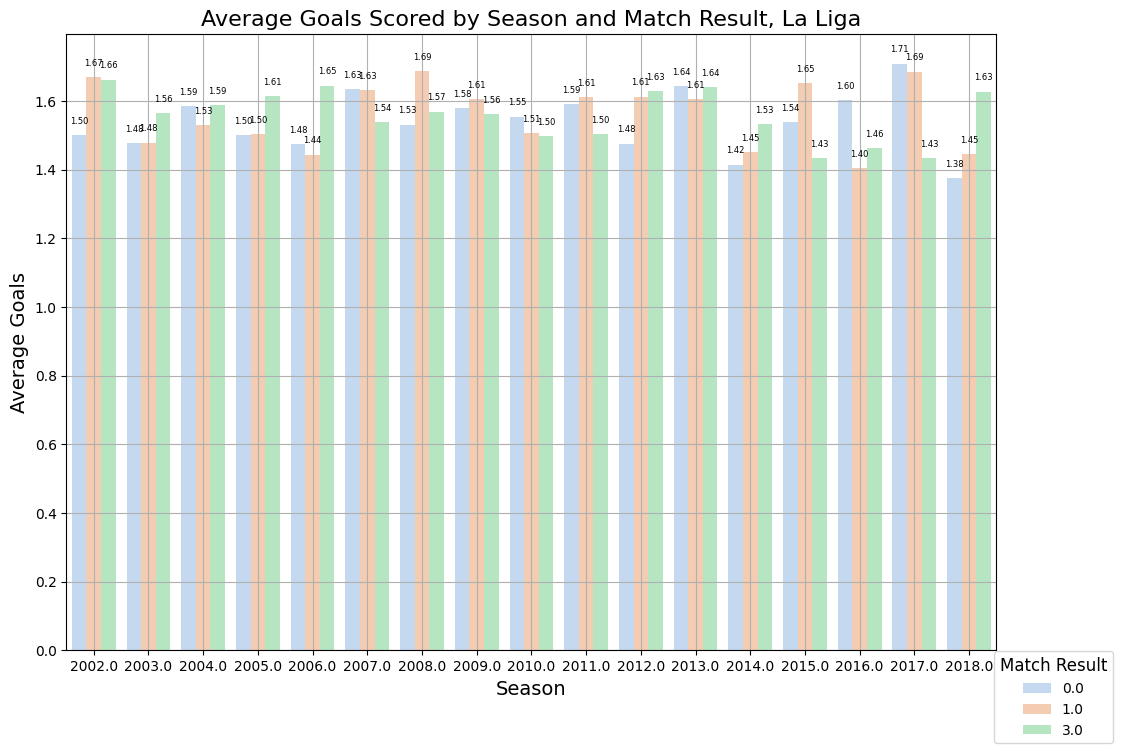

In [106]:
import seaborn as sns

# Step 1: Filter rows in merged_df
primera_df = merged_df[merged_df['Competition'] == 'primera-division']

# Step 2: Group by year and match result
grouped_df = primera_df.groupby(['season', 'Team_Points'])

# Step 3: Calculate average goals scored and allowed
mean_goals = grouped_df[['Team_Score', 'Opponent_Score']].mean().reset_index()

# Convert Team_Points to string
mean_goals['Team_Points'] = mean_goals['Team_Points'].astype(str)

# Convert 'season' to float
mean_goals['season'] = mean_goals['season'].astype(float)

# Convert 'Team_Points' to float
mean_goals['Team_Points'] = mean_goals['Team_Points'].astype(float)

# Check data types after conversion
print(mean_goals.dtypes)

# Set color palette for Win, Draw, Loss
palette = sns.color_palette("pastel", n_colors=3)

# Define the order of hue levels
hue_order = ['Win', 'Draw', 'Loss']

# Step 4: Create a plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot average goals for wins, draws, and losses 
sns.barplot(data=mean_goals, x='season', y='Team_Score', hue='Team_Points', palette=palette, alpha=0.7)

# Annotate with text at the top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=6)
# Customize the plot
ax.set_title('Average Goals Scored by Season and Match Result, La Liga', fontsize=16)
ax.set_xlabel('Season', fontsize=14)
ax.set_ylabel('Average Goals', fontsize=14)
ax.legend(title='Match Result', title_fontsize='12', fontsize='10', loc='upper left', bbox_to_anchor=(0.99, 0.01))
ax.grid(True)


# Show the plot
plt.show()

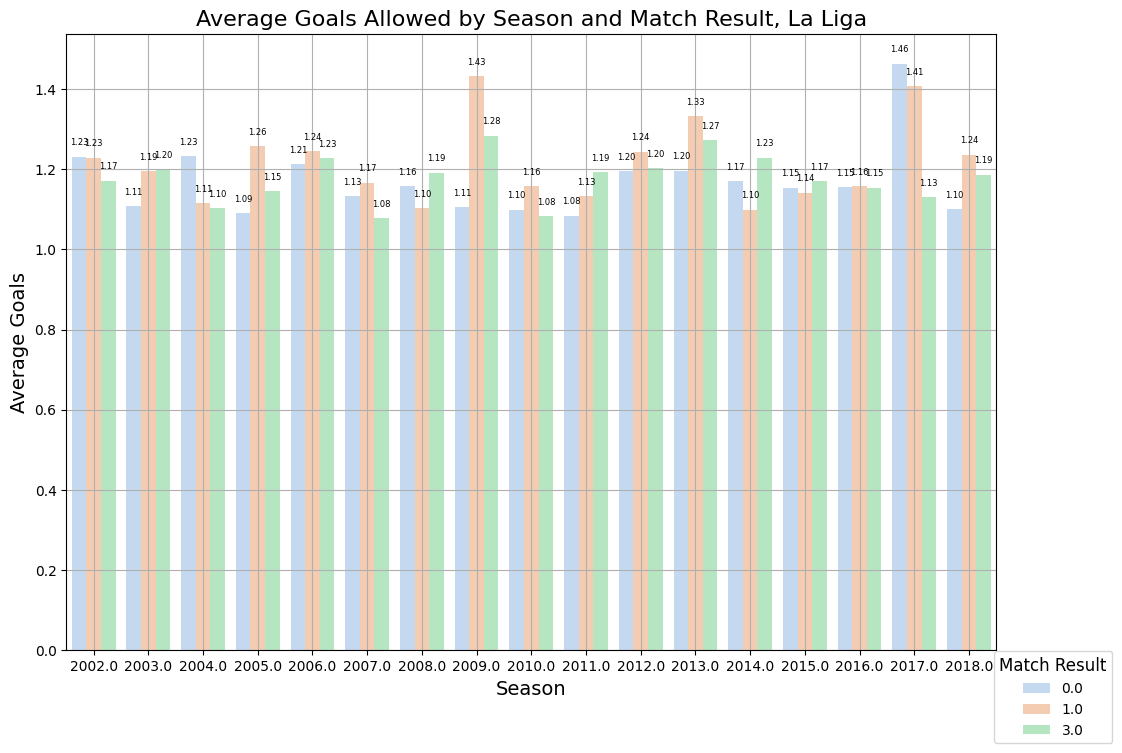

In [107]:
#Do it again for goals allowed
palette = sns.color_palette("pastel", n_colors=3)

# Define the order of hue levels
hue_order = ['Win', 'Draw', 'Loss']

fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(data=mean_goals, x='season', y='Opponent_Score', hue='Team_Points', palette=palette, alpha=0.7)
# Annotate with text at the top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=6)
# Customize the plot
ax.set_title('Average Goals Allowed by Season and Match Result, La Liga', fontsize=16)
ax.set_xlabel('Season', fontsize=14)
ax.set_ylabel('Average Goals', fontsize=14)
ax.legend(title='Match Result', title_fontsize='12', fontsize='10', loc='upper left', bbox_to_anchor=(0.99, 0.01))
ax.grid(True)


# Show the plot
plt.show()

*Based on these two graphs, there isn't a substantive relationship between a team's match result and how many goals they score or concede, so if I want to add these parameters into a model they should not play much of a role.*

*What about if I did Home and Away?*

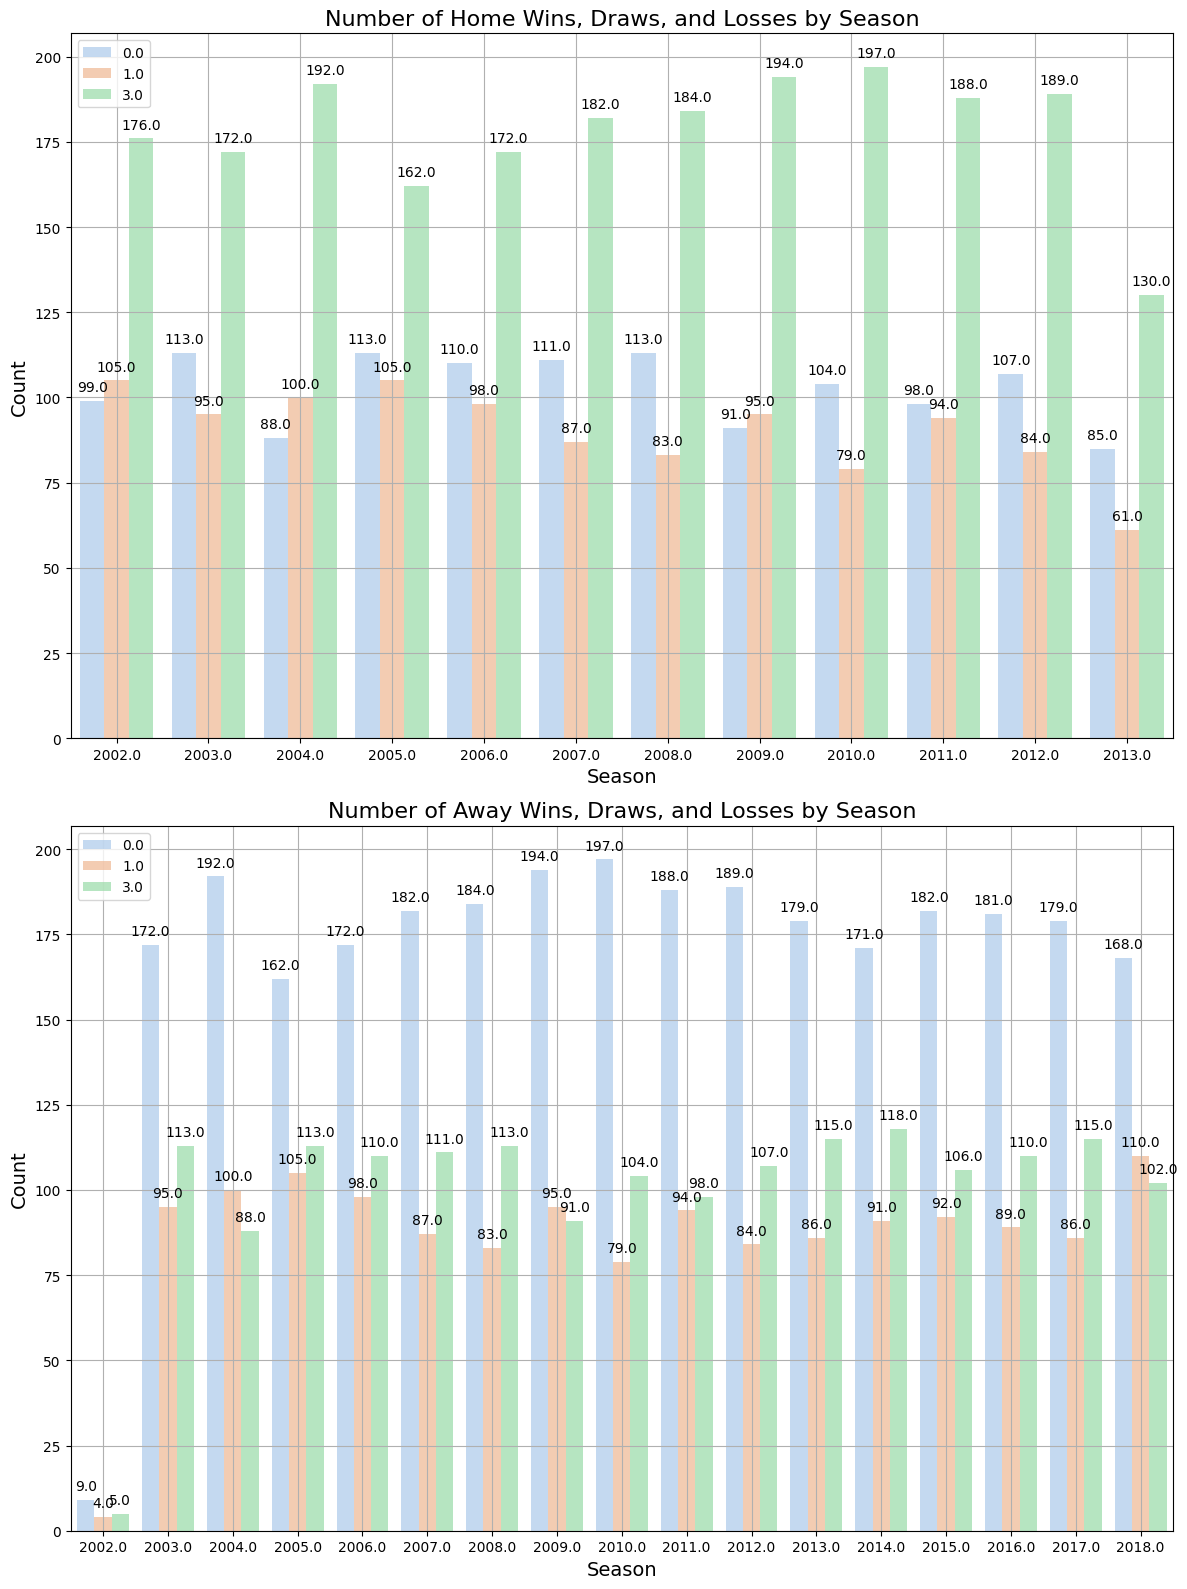

In [108]:
# Create separate DataFrames for home and away matches
home_df = primera_df[primera_df['Location'] == 'Home']
away_df = primera_df[primera_df['Location'] == 'Away']

# Group by season and team points for home matches
home_grouped = home_df.groupby(['season', 'Team_Points']).size().reset_index(name='Home_Count')

# Group by season and team points for away matches
away_grouped = away_df.groupby(['season', 'Team_Points']).size().reset_index(name='Away_Count')

# Create a color palette
palette = sns.color_palette("pastel", n_colors=len(home_grouped['Team_Points'].unique()))

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))

# Plot results for home matches
sns.barplot(data=home_grouped, x='season', y='Home_Count', hue='Team_Points', palette=palette, alpha=0.7, ax=ax1)

# Annotate with text at the top of each bar for home matches
for p in ax1.patches:
    ax1.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=10)

# Customize the plot for home matches
ax1.set_title('Number of Home Wins, Draws, and Losses by Season', fontsize=16)
ax1.set_xlabel('Season', fontsize=14)
ax1.set_ylabel('Count', fontsize=14)

ax1.legend(loc='upper left')

ax1.grid(True)

# Plot results for away matches
sns.barplot(data=away_grouped, x='season', y='Away_Count', hue='Team_Points', palette=palette, alpha=0.7, ax=ax2)

# Annotate with text at the top of each bar for away matches
for p in ax2.patches:
    ax2.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=10)

# Customize the plot for away matches
ax2.set_title('Number of Away Wins, Draws, and Losses by Season', fontsize=16)
ax2.set_xlabel('Season', fontsize=14)
ax2.set_ylabel('Count', fontsize=14)

ax2.legend(loc='upper left')

ax2.grid(True)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


*Uh oh! It looks like there isn't Home data for the 2014-2018 seasons, so let's check:*

In [109]:
# Count the number of home and away matches
location_counts = primera_df['Location'].value_counts()

# Display the counts
print(location_counts)

print(home_df['season'].unique())
print(away_df['season'].unique())


Location
Away    6098
Home    4456
Name: count, dtype: int64
['2002.0' '2003.0' '2004.0' '2005.0' '2006.0' '2007.0' '2008.0' '2009.0'
 '2010.0' '2011.0' '2012.0' '2013.0']
['2002.0' '2003.0' '2004.0' '2005.0' '2006.0' '2007.0' '2008.0' '2009.0'
 '2010.0' '2011.0' '2012.0' '2013.0' '2014.0' '2015.0' '2016.0' '2017.0'
 '2018.0']


*Now that we've confirmed this, it looks like we'll have to cut out the Away data from 2014-2018. Becuase we looked in primera_df, we can be sure that there just isn't data stored for those seasons. Additionally, it looks like there's missing data from the 2002 season. So, let's try again, this time cutting out the extra data:*

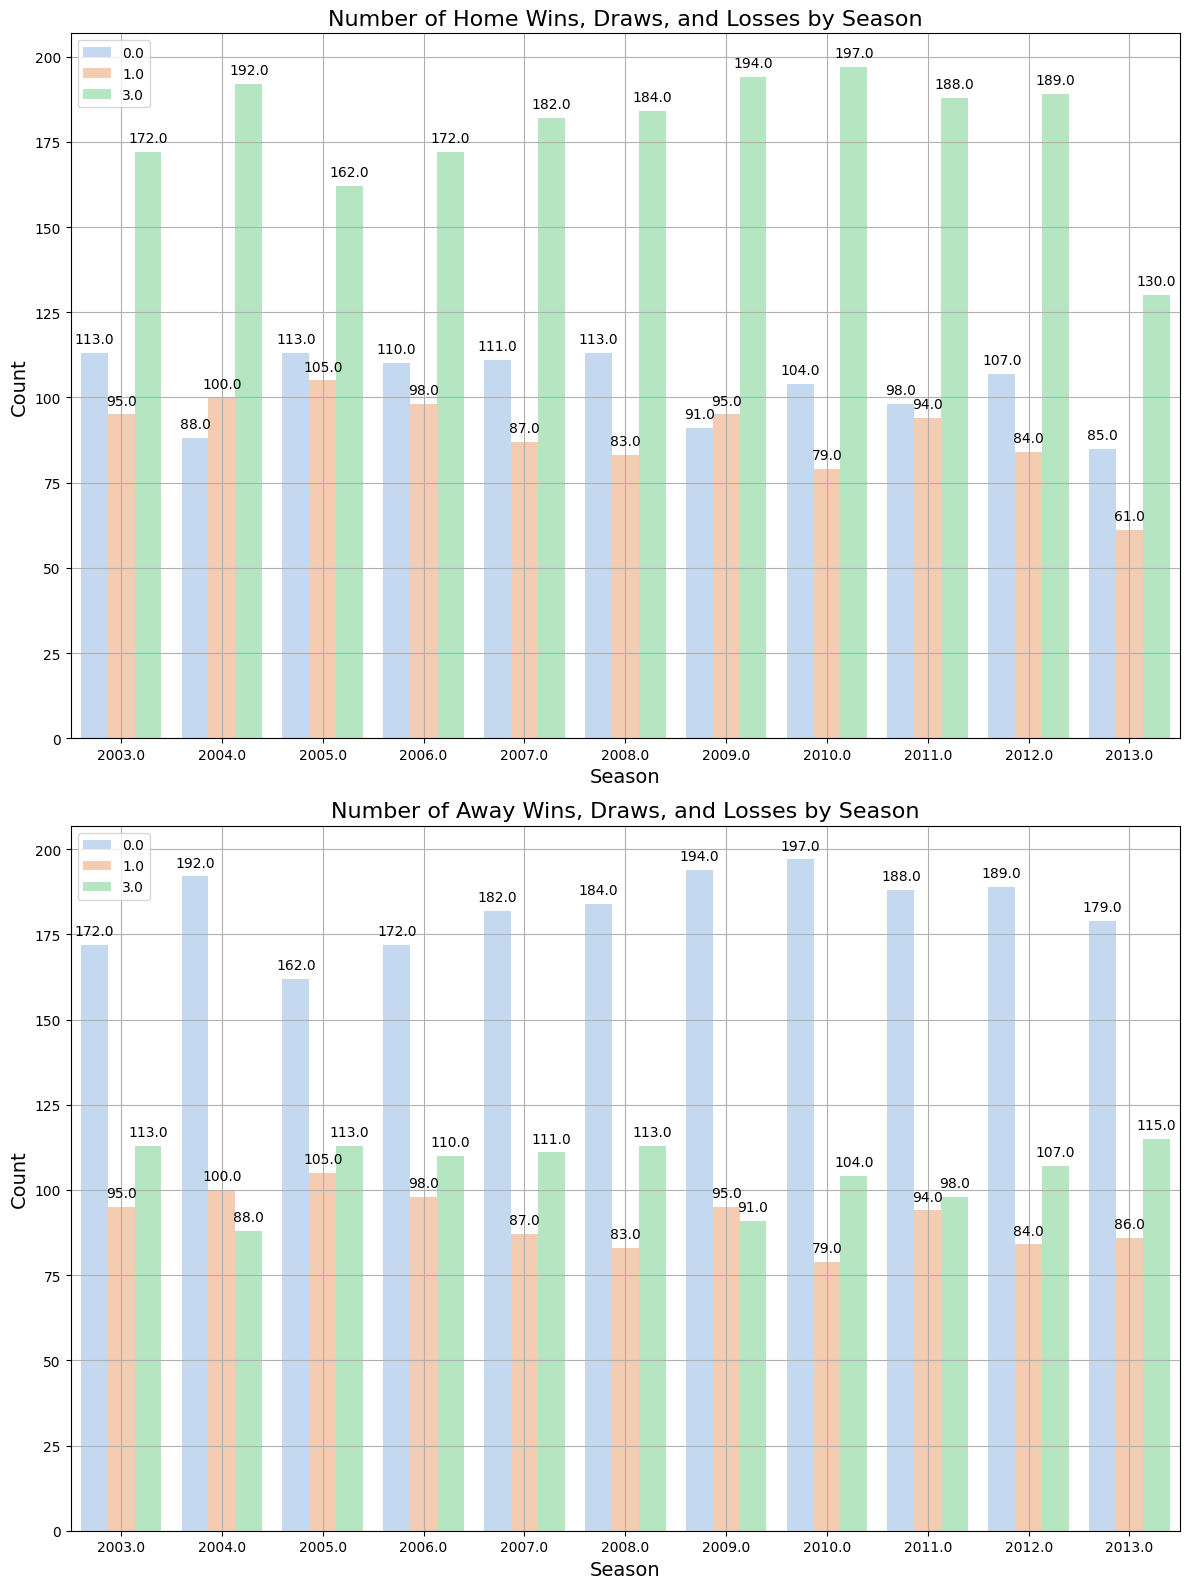

In [110]:
# Assuming primera_df is already filtered for the desired competition and has 'Location' column

# Filter out data from the 2014 season onward
filtered_primera_df = primera_df[primera_df['season'].astype(float) < 2014]

#Filter out data from the 2002 season
filtered_primera_df = filtered_primera_df[filtered_primera_df['season'].astype(float) > 2002]

# Create separate DataFrames for home and away matches
home_df = filtered_primera_df[filtered_primera_df['Location'] == 'Home']
away_df = filtered_primera_df[filtered_primera_df['Location'] == 'Away']

# Group by season and team points for home matches
home_grouped = home_df.groupby(['season', 'Team_Points']).size().reset_index(name='Home_Count')

# Group by season and team points for away matches
away_grouped = away_df.groupby(['season', 'Team_Points']).size().reset_index(name='Away_Count')

# Create a color palette
palette = sns.color_palette("pastel", n_colors=len(home_grouped['Team_Points'].unique()))

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))

# Plot results for home matches
sns.barplot(data=home_grouped, x='season', y='Home_Count', hue='Team_Points', palette=palette, alpha=0.7, ax=ax1)

# Annotate with text at the top of each bar for home matches
for p in ax1.patches:
    ax1.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=10)

# Customize the plot for home matches
ax1.set_title('Number of Home Wins, Draws, and Losses by Season', fontsize=16)
ax1.set_xlabel('Season', fontsize=14)
ax1.set_ylabel('Count', fontsize=14)

ax1.legend(loc='upper left')

ax1.grid(True)

# Plot results for away matches
sns.barplot(data=away_grouped, x='season', y='Away_Count', hue='Team_Points', palette=palette, alpha=0.7, ax=ax2)

# Annotate with text at the top of each bar for away matches
for p in ax2.patches:
    ax2.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=10)

# Customize the plot for away matches
ax2.set_title('Number of Away Wins, Draws, and Losses by Season', fontsize=16)
ax2.set_xlabel('Season', fontsize=14)
ax2.set_ylabel('Count', fontsize=14)

ax2.legend(loc='upper left')

ax2.grid(True)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

*Now we finally have what looks like a real relationship! It is very clear that the team that plays at home has a very good chance at winning (and thus the team playing on the road has a good chance of losing). The last thing I want to look at before creating a model is the relationship between HT scores and FT scores. I'll start with just that and maybe afterwards I'll specify by Home and Away.*

/tmp/ipykernel_42/2854282722.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  goal_diff_df['Goal_Differential_HT'] = pd.to_numeric(goal_diff_df['Goal_Differential_HT'], errors='coerce')
/tmp/ipykernel_42/2854282722.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  goal_diff_df['Goal_Differential_FT'] = pd.to_numeric(goal_diff_df['Goal_Differential_FT'], errors='coerce')


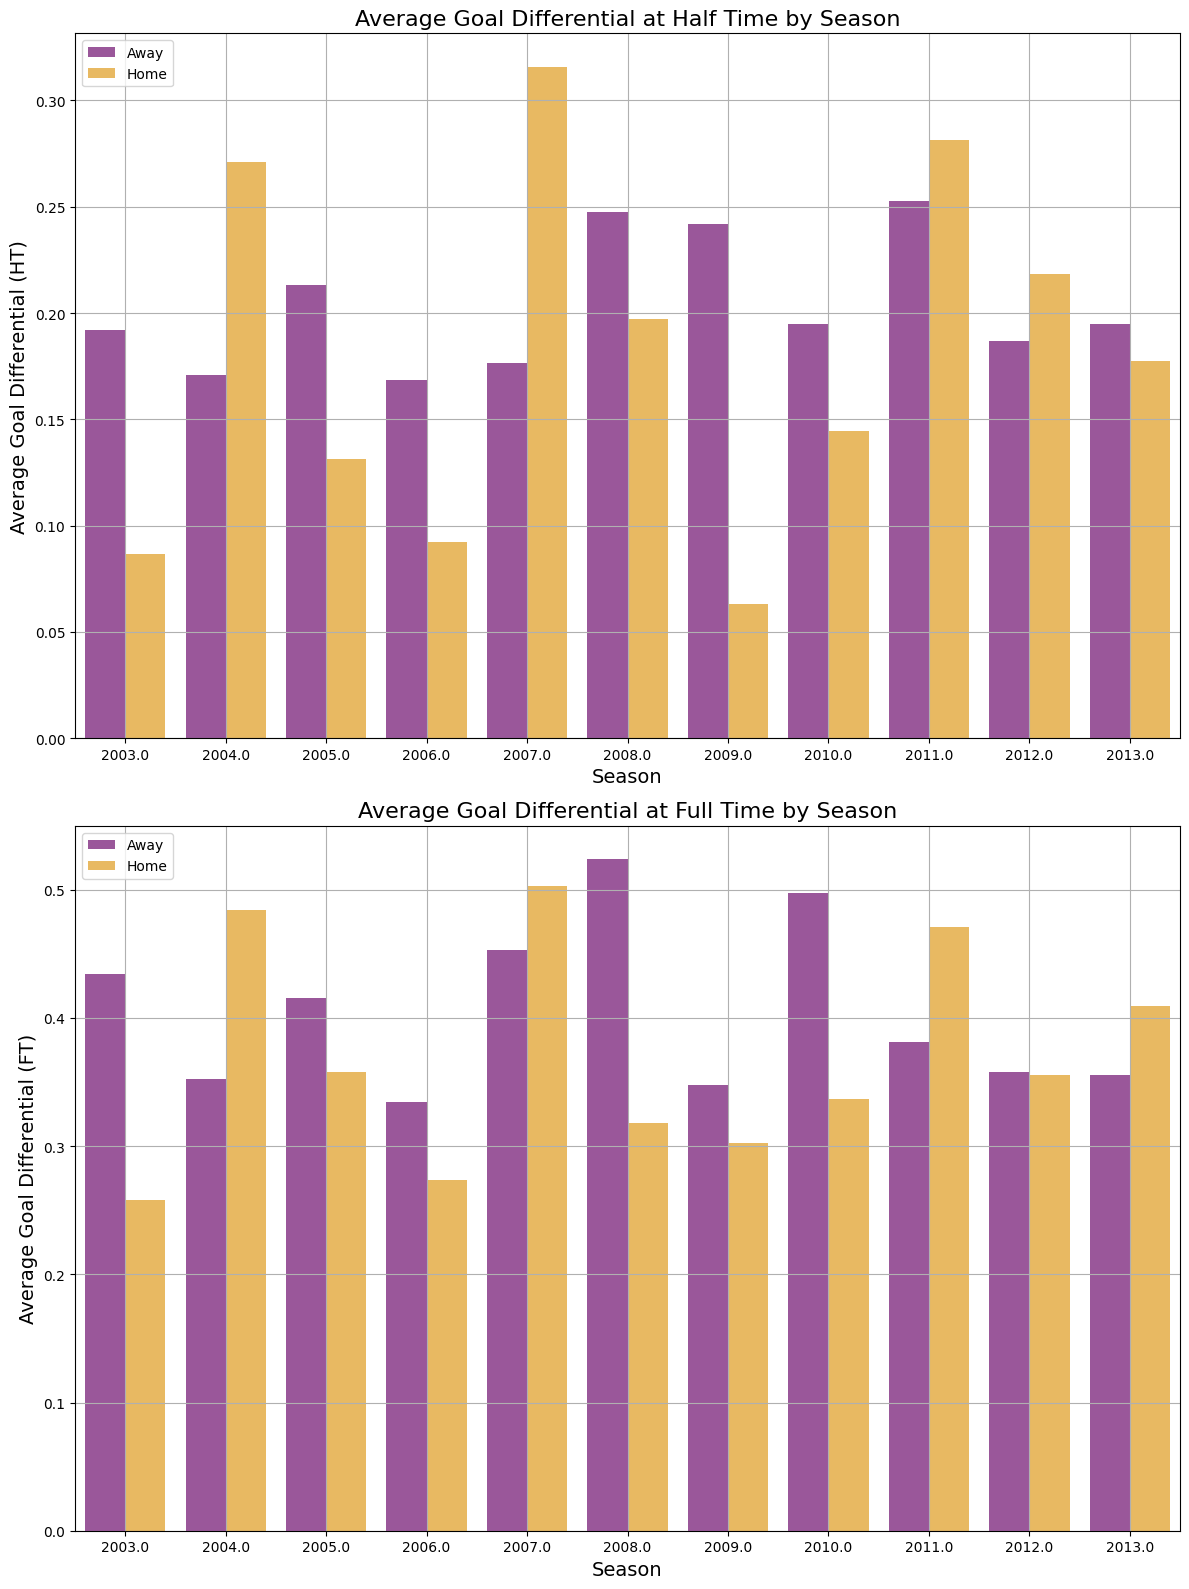

In [111]:
primera_df = filtered_primera_df

# Filter the DataFrame for relevant columns
goal_diff_df = primera_df[['season', 'Location', 'Goal_Differential_HT', 'Goal_Differential_FT']]

# Convert goal differential columns to numeric
goal_diff_df['Goal_Differential_HT'] = pd.to_numeric(goal_diff_df['Goal_Differential_HT'], errors='coerce')
goal_diff_df['Goal_Differential_FT'] = pd.to_numeric(goal_diff_df['Goal_Differential_FT'], errors='coerce')

# Group by season, location, and calculate mean
grouped_goal_diff = goal_diff_df.groupby(['season', 'Location']).mean().reset_index()

# Create a color palette
palette = sns.color_palette(["purple", "orange"], n_colors=2)

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))

# Plot average goal differential at half time
sns.barplot(data=grouped_goal_diff, x='season', y='Goal_Differential_HT', hue='Location', palette=palette, alpha=0.7, ax=ax1)

# Customize the plot for half time
ax1.set_title('Average Goal Differential at Half Time by Season', fontsize=16)
ax1.set_xlabel('Season', fontsize=14)
ax1.set_ylabel('Average Goal Differential (HT)', fontsize=14)

ax1.legend(loc='upper left')
ax1.grid(True)

# Plot average goal differential at full time
sns.barplot(data=grouped_goal_diff, x='season', y='Goal_Differential_FT', hue='Location', palette=palette, alpha=0.7, ax=ax2)

# Customize the plot for full time
ax2.set_title('Average Goal Differential at Full Time by Season', fontsize=16)
ax2.set_xlabel('Season', fontsize=14)
ax2.set_ylabel('Average Goal Differential (FT)', fontsize=14)

ax2.legend(loc='upper left')
ax2.grid(True)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [112]:
print(grouped_goal_diff)

    season Location  Goal_Differential_HT  Goal_Differential_FT
0   2003.0     Away              0.192105              0.434211
1   2003.0     Home              0.086842              0.257895
2   2004.0     Away              0.171053              0.352632
3   2004.0     Home              0.271053              0.484211
4   2005.0     Away              0.213158              0.415789
5   2005.0     Home              0.131579              0.357895
6   2006.0     Away              0.168421              0.334211
7   2006.0     Home              0.092105              0.273684
8   2007.0     Away              0.176316              0.452632
9   2007.0     Home              0.315789              0.502632
10  2008.0     Away              0.247368              0.523684
11  2008.0     Home              0.197368              0.318421
12  2009.0     Away              0.242105              0.347368
13  2009.0     Home              0.063158              0.302632
14  2010.0     Away              0.19473

/tmp/ipykernel_42/3278505110.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  home_df['Goal_Differential_HT_Category'] = pd.cut(home_df['Goal_Differential_HT'], bins=[float('-inf'), 0, float('inf')],
/tmp/ipykernel_42/3278505110.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  home_df['Goal_Differential_FT_Category'] = pd.cut(home_df['Goal_Differential_FT'], bins=[float('-inf'), 0, float('inf')],
/tmp/ipykernel_42/3278505110.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

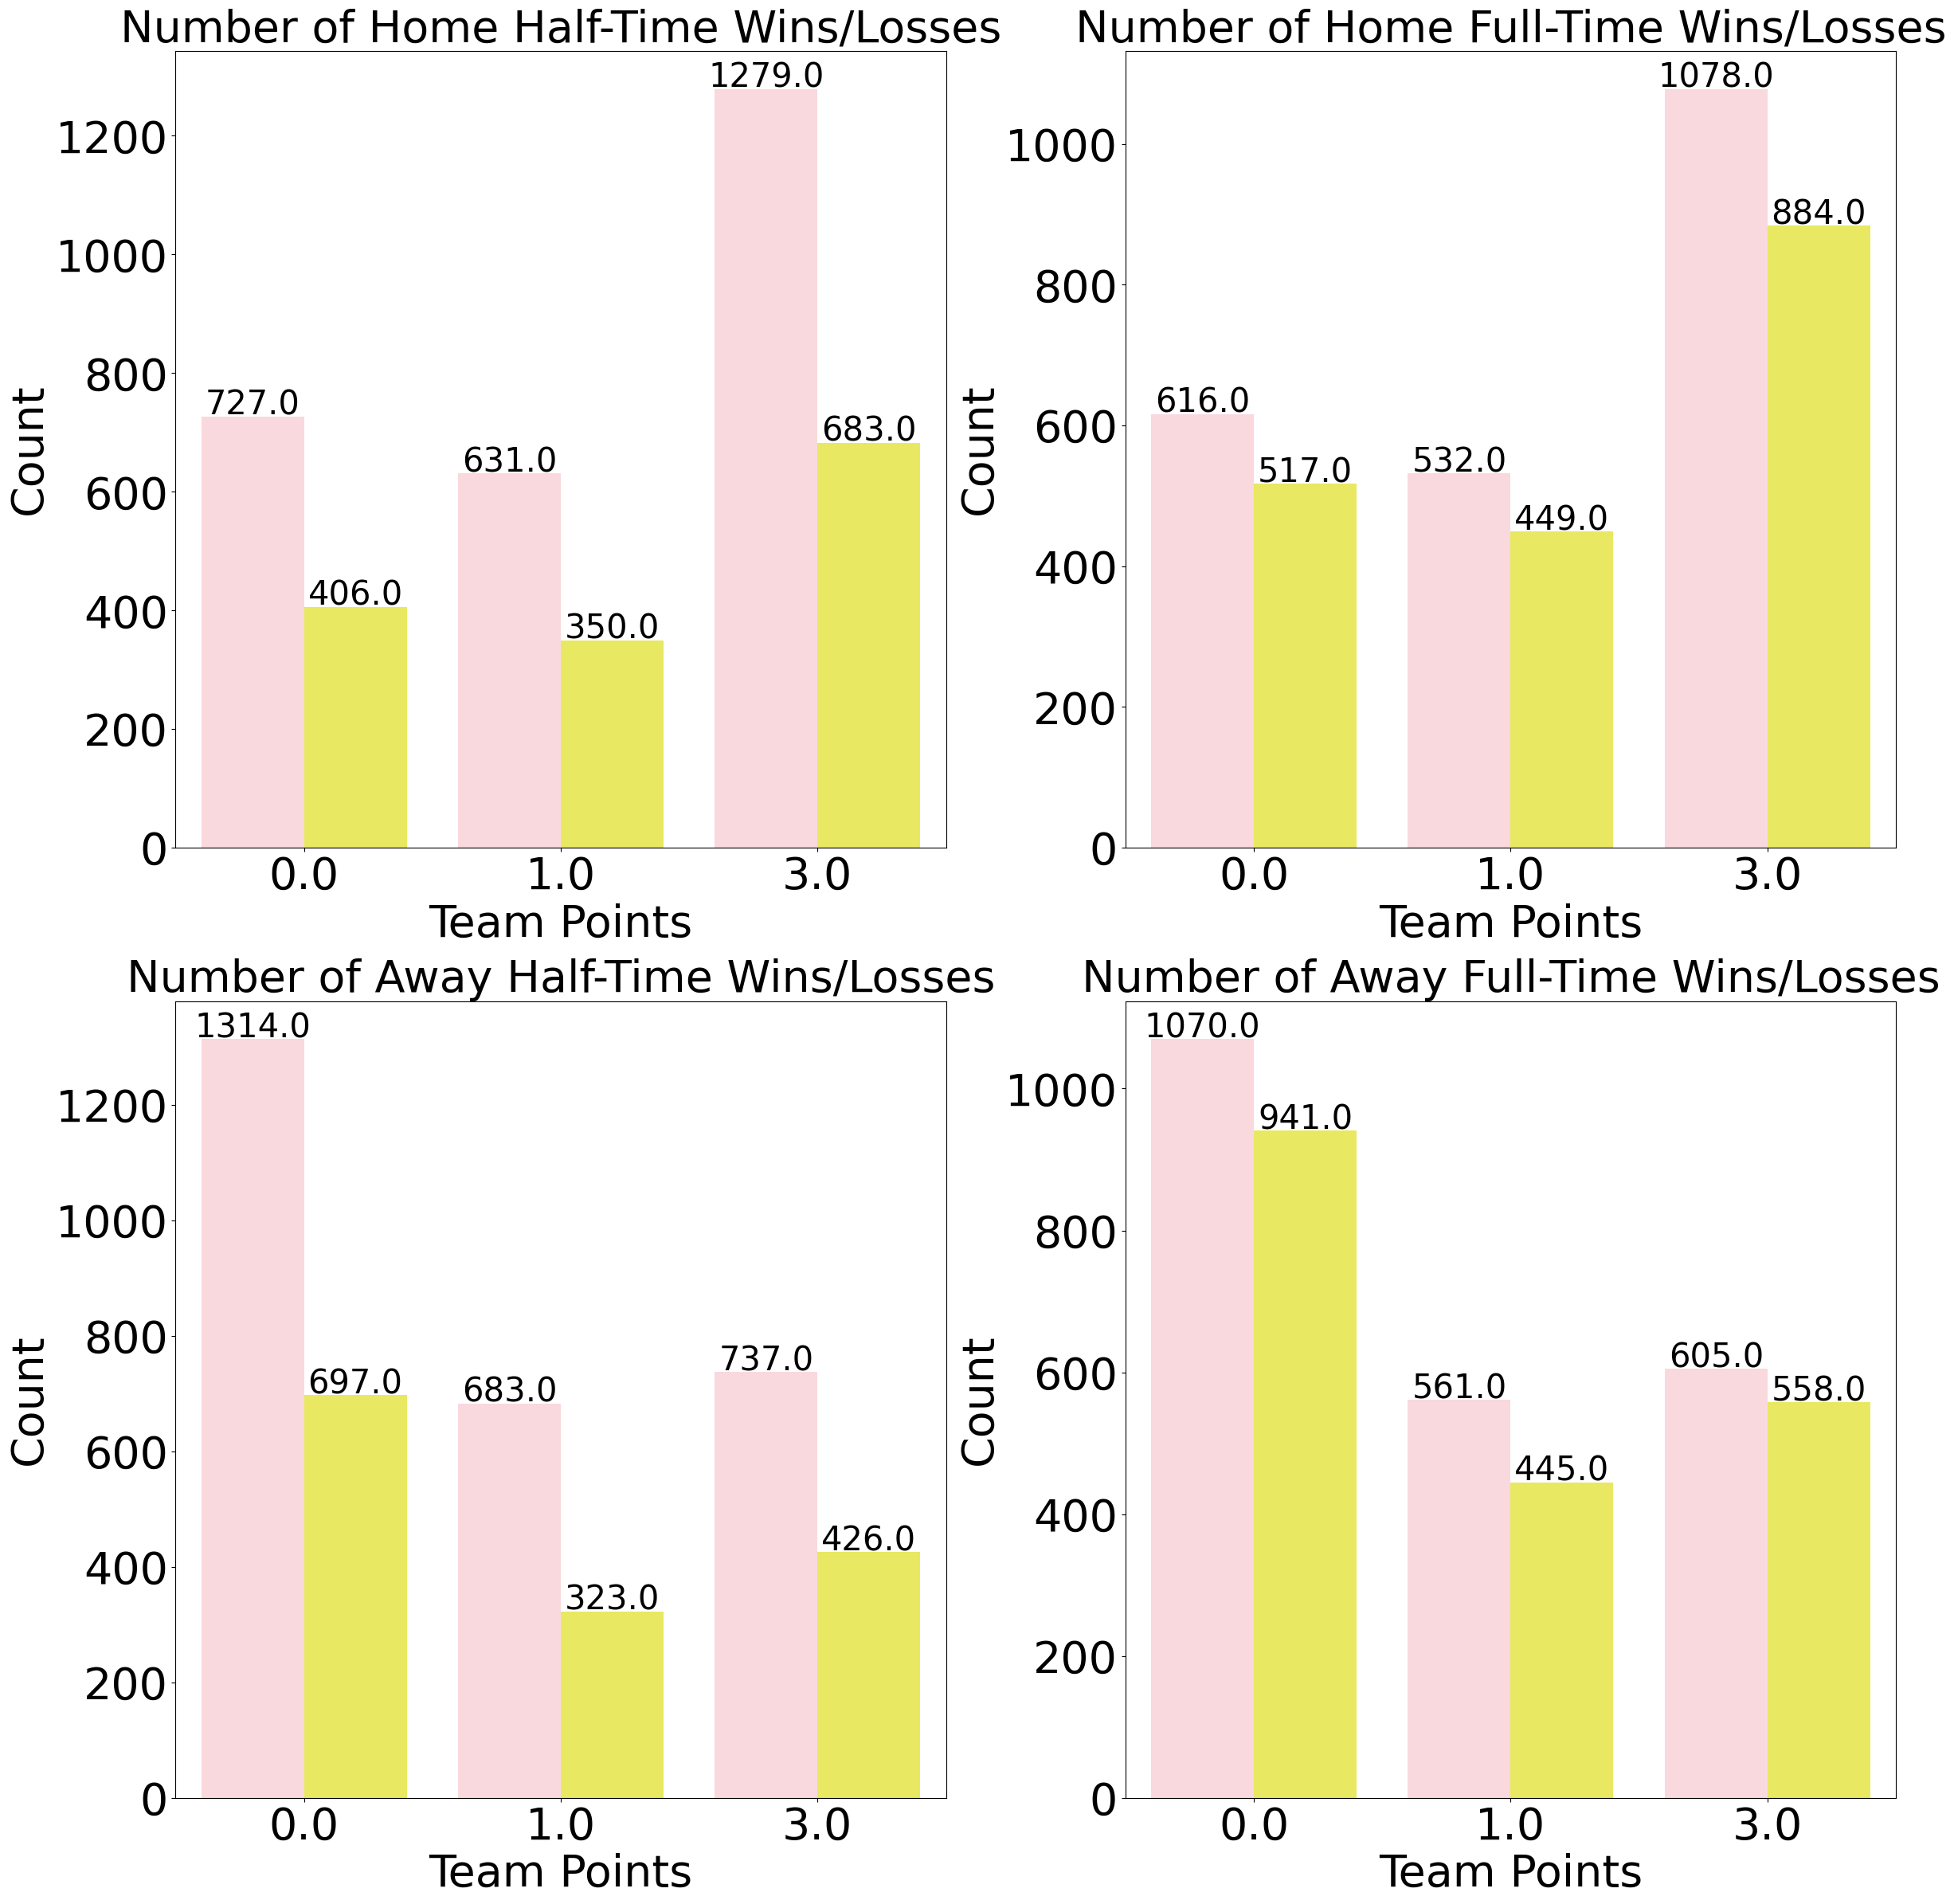

In [113]:
# Create separate DataFrames for home and away matches
home_df = primera_df[primera_df['Location'] == 'Home']
away_df = primera_df[primera_df['Location'] == 'Away']

# Categorize goal differentials at half-time for home matches
home_df['Goal_Differential_HT_Category'] = pd.cut(home_df['Goal_Differential_HT'], bins=[float('-inf'), 0, float('inf')],
                                                labels=['HT_Loss', 'HT_Win'])

# Categorize goal differentials at full-time for home matches
home_df['Goal_Differential_FT_Category'] = pd.cut(home_df['Goal_Differential_FT'], bins=[float('-inf'), 0, float('inf')],
                                                labels=['FT_Loss', 'FT_Win'])

# Categorize goal differentials at half-time for away matches
away_df['Goal_Differential_HT_Category'] = pd.cut(away_df['Goal_Differential_HT'], bins=[float('-inf'), 0, float('inf')],
                                                labels=['HT_Loss', 'HT_Win'])

# Categorize goal differentials at full-time for away matches
away_df['Goal_Differential_FT_Category'] = pd.cut(away_df['Goal_Differential_FT'], bins=[float('-inf'), 0, float('inf')],
                                                labels=['FT_Loss', 'FT_Win'])

# Group by team points and half-time goal differential for home matches
home_grouped_ht = home_df.groupby(['Team_Points', 'Goal_Differential_HT_Category']).size().reset_index(name='Home_HT_Count')

# Group by team points and full-time goal differential for home matches
home_grouped_ft = home_df.groupby(['Team_Points', 'Goal_Differential_FT_Category']).size().reset_index(name='Home_FT_Count')

# Group by team points and half-time goal differential for away matches
away_grouped_ht = away_df.groupby(['Team_Points', 'Goal_Differential_HT_Category']).size().reset_index(name='Away_HT_Count')

# Group by team points and full-time goal differential for away matches
away_grouped_ft = away_df.groupby(['Team_Points', 'Goal_Differential_FT_Category']).size().reset_index(name='Away_FT_Count')

# Create a color palette
palette = sns.color_palette(["pink", "yellow"], n_colors=2)

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(24, 24))

# Plot results for home matches at half-time
sns.barplot(data=home_grouped_ht, x='Team_Points', y='Home_HT_Count', hue='Goal_Differential_HT_Category', palette=palette, alpha=0.7, ax=axs[0, 0], linewidth=0, hue_order=['HT_Loss', 'HT_Win'])

# Annotate with text at the top of each bar for home matches at half-time
for p in axs[0, 0].patches:
    axs[0, 0].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=30)

# Adjust x and y ticks size for home matches at half-time
axs[0, 0].tick_params(axis='x', labelsize=40)
axs[0, 0].tick_params(axis='y', labelsize=40)

# Customize the plot for home matches at half-time
axs[0, 0].set_title('Number of Home Half-Time Wins/Losses', fontsize=40)
axs[0, 0].set_xlabel('Team Points', fontsize=40)
axs[0, 0].set_ylabel('Count', fontsize=40)

# Remove legend
axs[0, 0].legend().set_visible(False)

# Plot results for home matches at full-time
sns.barplot(data=home_grouped_ft, x='Team_Points', y='Home_FT_Count', hue='Goal_Differential_FT_Category', palette=palette, alpha=0.7, ax=axs[0, 1], linewidth=0, hue_order=['FT_Loss', 'FT_Win'])

# Annotate with text at the top of each bar for home matches at full-time
for p in axs[0, 1].patches:
    axs[0, 1].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=30)

# Adjust x and y ticks size for home matches at full-time
axs[0, 1].tick_params(axis='x', labelsize=40)
axs[0, 1].tick_params(axis='y', labelsize=40)

# Customize the plot for home matches at full-time
axs[0, 1].set_title('Number of Home Full-Time Wins/Losses', fontsize=40)
axs[0, 1].set_xlabel('Team Points', fontsize=40)
axs[0, 1].set_ylabel('Count', fontsize=40)

# Remove legend
axs[0, 1].legend().set_visible(False)

# Plot results for away matches at half-time
sns.barplot(data=away_grouped_ht, x='Team_Points', y='Away_HT_Count', hue='Goal_Differential_HT_Category', palette=palette, alpha=0.7, ax=axs[1, 0], linewidth=0, hue_order=['HT_Loss', 'HT_Win'])

# Annotate with text at the top of each bar for away matches at half-time
for p in axs[1, 0].patches:
    axs[1, 0].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=30)

# Adjust x and y ticks size for away matches at half-time
axs[1, 0].tick_params(axis='x', labelsize=40)
axs[1, 0].tick_params(axis='y', labelsize=40)

# Customize the plot for away matches at half-time
axs[1, 0].set_title('Number of Away Half-Time Wins/Losses', fontsize=40)
axs[1, 0].set_xlabel('Team Points', fontsize=40)
axs[1, 0].set_ylabel('Count', fontsize=40)

# Remove legend
axs[1, 0].legend().set_visible(False)

# Plot results for away matches at full-time
sns.barplot(data=away_grouped_ft, x='Team_Points', y='Away_FT_Count', hue='Goal_Differential_FT_Category', palette=palette, alpha=0.7, ax=axs[1, 1], linewidth=0, hue_order=['FT_Loss', 'FT_Win'])

# Annotate with text at the top of each bar for away matches at full-time
for p in axs[1, 1].patches:
    axs[1, 1].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=30)

# Adjust x and y ticks size for away matches at full-time
axs[1, 1].tick_params(axis='x', labelsize=40)
axs[1, 1].tick_params(axis='y', labelsize=40)

# Customize the plot for away matches at full-time
axs[1, 1].set_title('Number of Away Full-Time Wins/Losses', fontsize=40)
axs[1, 1].set_xlabel('Team Points', fontsize=40)
axs[1, 1].set_ylabel('Count', fontsize=40)

# Remove legend
axs[1, 1].legend().set_visible(False)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


*We see here that across all years, the half time result generally predicts the full time result, as we don't see any extreme changes in the graphs when looking left to right. I am satisfied with the analysis I've done, especially this last bit of code, and I'm gonna try to create a model to predict, based on some of the analysis I've done, the results for a 38-game La Liga season. The idea is that, if I give the model certain inputs (like goal differential, percentage of home and away matches won/drawn/lost, etc.), it can try to predict a season's worth of games. This might be tricky, but I'm willing to give it a shot.*

Creating the Model

*I'm gonna start by adding statistics. A lot. But they will be useful for the model I think.*

In [114]:
# Convert 'Team_Points' to numeric 
primera_df['Team_Points'] = pd.to_numeric(primera_df['Team_Points'])

# Calculate percentage of total wins, draws, and losses
primera_df['Percentage_Total_Wins'] = primera_df[primera_df['Team_Points'] == 3.0].groupby('Team')['Team_Points'].transform('count') / primera_df.groupby('Team')['Team_Points'].transform('count') 
primera_df['Percentage_Total_Draws'] = primera_df[primera_df['Team_Points'] == 1.0].groupby('Team')['Team_Points'].transform('count') / primera_df.groupby('Team')['Team_Points'].transform('count') 
primera_df['Percentage_Total_Losses'] = primera_df[primera_df['Team_Points'] == 0.0].groupby('Team')['Team_Points'].transform('count') / primera_df.groupby('Team')['Team_Points'].transform('count') 

# Calculate percentage of home wins, draws, and losses
primera_df['Percentage_Home_Wins'] = primera_df[(primera_df['Team_Points'] == 3.0) & (primera_df['Location'] == 'Home')].groupby('Team')['Team_Points'].transform('count') / primera_df[primera_df['Location'] == 'Home'].groupby('Team')['Team_Points'].transform('count') 
primera_df['Percentage_Home_Draws'] = primera_df[(primera_df['Team_Points'] == 1.0) & (primera_df['Location'] == 'Home')].groupby('Team')['Team_Points'].transform('count') / primera_df[primera_df['Location'] == 'Home'].groupby('Team')['Team_Points'].transform('count') 
primera_df['Percentage_Home_Losses'] = primera_df[(primera_df['Team_Points'] == 0.0) & (primera_df['Location'] == 'Home')].groupby('Team')['Team_Points'].transform('count') / primera_df[primera_df['Location'] == 'Home'].groupby('Team')['Team_Points'].transform('count') 

# Calculate percentage of away wins, draws, and losses
primera_df['Percentage_Away_Wins'] = primera_df[(primera_df['Team_Points'] == 3.0) & (primera_df['Location'] == 'Away')].groupby('Team')['Team_Points'].transform('count') / primera_df[primera_df['Location'] == 'Away'].groupby('Team')['Team_Points'].transform('count') 
primera_df['Percentage_Away_Draws'] = primera_df[(primera_df['Team_Points'] == 1.0) & (primera_df['Location'] == 'Away')].groupby('Team')['Team_Points'].transform('count') / primera_df[primera_df['Location'] == 'Away'].groupby('Team')['Team_Points'].transform('count') 
primera_df['Percentage_Away_Losses'] = primera_df[(primera_df['Team_Points'] == 0.0) & (primera_df['Location'] == 'Away')].groupby('Team')['Team_Points'].transform('count') / primera_df[primera_df['Location'] == 'Away'].groupby('Team')['Team_Points'].transform('count') 

# Categorize halftime situations
primera_df['HT_Category'] = pd.cut(primera_df['Goal_Differential_HT'], bins=[float('-inf'), 0, 0.1, float('inf')],
                                   labels=['Losing', 'Tying', 'Winning'])

# Calculate percentage of home wins when winning, tying, and losing at halftime
primera_df['Percentage_Home_Wins_When_Winning_HT'] = primera_df[
    (primera_df['Team_Points'] == 3.0) & (primera_df['Location'] == 'Home') & (primera_df['HT_Category'] == 'Winning')
].groupby('Team')['Team_Points'].transform('count') / primera_df[
    (primera_df['Location'] == 'Home') & (primera_df['HT_Category'] == 'Winning')
].groupby('Team')['Team_Points'].transform('count') 

primera_df['Percentage_Home_Wins_When_Tied_HT'] = primera_df[
    (primera_df['Team_Points'] == 3.0) & (primera_df['Location'] == 'Home') & (primera_df['HT_Category'] == 'Tying')
].groupby('Team')['Team_Points'].transform('count') / primera_df[
    (primera_df['Location'] == 'Home') & (primera_df['HT_Category'] == 'Tying')
].groupby('Team')['Team_Points'].transform('count') 

primera_df['Percentage_Home_Wins_When_Losing_HT'] = primera_df[
    (primera_df['Team_Points'] == 3.0) & (primera_df['Location'] == 'Home') & (primera_df['HT_Category'] == 'Losing')
].groupby('Team')['Team_Points'].transform('count') / primera_df[
    (primera_df['Location'] == 'Home') & (primera_df['HT_Category'] == 'Losing')
].groupby('Team')['Team_Points'].transform('count') 

# Calculate percentage of home draws when winning, tying, and losing at halftime
primera_df['Percentage_Home_Draws_When_Winning_HT'] = primera_df[
    (primera_df['Team_Points'] == 1.0) & (primera_df['Location'] == 'Home') & (primera_df['HT_Category'] == 'Winning')
].groupby('Team')['Team_Points'].transform('count') / primera_df[
    (primera_df['Location'] == 'Home') & (primera_df['HT_Category'] == 'Winning')
].groupby('Team')['Team_Points'].transform('count') 

primera_df['Percentage_Home_Draws_When_Tied_HT'] = primera_df[
    (primera_df['Team_Points'] == 1.0) & (primera_df['Location'] == 'Home') & (primera_df['HT_Category'] == 'Tying')
].groupby('Team')['Team_Points'].transform('count') / primera_df[
    (primera_df['Location'] == 'Home') & (primera_df['HT_Category'] == 'Tying')
].groupby('Team')['Team_Points'].transform('count') 

primera_df['Percentage_Home_Draws_When_Losing_HT'] = primera_df[
    (primera_df['Team_Points'] == 1.0) & (primera_df['Location'] == 'Home') & (primera_df['HT_Category'] == 'Losing')
].groupby('Team')['Team_Points'].transform('count') / primera_df[
    (primera_df['Location'] == 'Home') & (primera_df['HT_Category'] == 'Losing')
].groupby('Team')['Team_Points'].transform('count') 

# Calculate percentage of home losses when winning, tying, and losing at halftime
primera_df['Percentage_Home_Losses_When_Winning_HT'] = primera_df[
    (primera_df['Team_Points'] == 0.0) & (primera_df['Location'] == 'Home') & (primera_df['HT_Category'] == 'Winning')
].groupby('Team')['Team_Points'].transform('count') / primera_df[
    (primera_df['Location'] == 'Home') & (primera_df['HT_Category'] == 'Winning')
].groupby('Team')['Team_Points'].transform('count') 

primera_df['Percentage_Home_Losses_When_Tied_HT'] = primera_df[
    (primera_df['Team_Points'] == 0.0) & (primera_df['Location'] == 'Home') & (primera_df['HT_Category'] == 'Tying')
].groupby('Team')['Team_Points'].transform('count') / primera_df[
    (primera_df['Location'] == 'Home') & (primera_df['HT_Category'] == 'Tying')
].groupby('Team')['Team_Points'].transform('count') 

primera_df['Percentage_Home_Losses_When_Losing_HT'] = primera_df[
    (primera_df['Team_Points'] == 0.0) & (primera_df['Location'] == 'Home') & (primera_df['HT_Category'] == 'Losing')
].groupby('Team')['Team_Points'].transform('count') / primera_df[
    (primera_df['Location'] == 'Home') & (primera_df['HT_Category'] == 'Losing')
].groupby('Team')['Team_Points'].transform('count')

# Calculate percentage of away wins when winning, tying, and losing at halftime
primera_df['Percentage_Away_Wins_When_Winning_HT'] = primera_df[
    (primera_df['Team_Points'] == 3.0) & (primera_df['Location'] == 'Away') & (primera_df['HT_Category'] == 'Winning')
].groupby('Team')['Team_Points'].transform('count') / primera_df[
    (primera_df['Location'] == 'Away') & (primera_df['HT_Category'] == 'Winning')
].groupby('Team')['Team_Points'].transform('count') 

primera_df['Percentage_Away_Wins_When_Tied_HT'] = primera_df[
    (primera_df['Team_Points'] == 3.0) & (primera_df['Location'] == 'Away') & (primera_df['HT_Category'] == 'Tying')
].groupby('Team')['Team_Points'].transform('count') / primera_df[
    (primera_df['Location'] == 'Away') & (primera_df['HT_Category'] == 'Tying')
].groupby('Team')['Team_Points'].transform('count') 

primera_df['Percentage_Away_Wins_When_Losing_HT'] = primera_df[
    (primera_df['Team_Points'] == 3.0) & (primera_df['Location'] == 'Away') & (primera_df['HT_Category'] == 'Losing')
].groupby('Team')['Team_Points'].transform('count') / primera_df[
    (primera_df['Location'] == 'Away') & (primera_df['HT_Category'] == 'Losing')
].groupby('Team')['Team_Points'].transform('count') 

# Calculate percentage of away draws when winning, tying, and losing at halftime
primera_df['Percentage_Away_Draws_When_Winning_HT'] = primera_df[
    (primera_df['Team_Points'] == 1.0) & (primera_df['Location'] == 'Away') & (primera_df['HT_Category'] == 'Winning')
].groupby('Team')['Team_Points'].transform('count') / primera_df[
    (primera_df['Location'] == 'Away') & (primera_df['HT_Category'] == 'Winning')
].groupby('Team')['Team_Points'].transform('count') 

primera_df['Percentage_Away_Draws_When_Tied_HT'] = primera_df[
    (primera_df['Team_Points'] == 1.0) & (primera_df['Location'] == 'Away') & (primera_df['HT_Category'] == 'Tying')
].groupby('Team')['Team_Points'].transform('count') / primera_df[
    (primera_df['Location'] == 'Away') & (primera_df['HT_Category'] == 'Tying')
].groupby('Team')['Team_Points'].transform('count') 

primera_df['Percentage_Away_Draws_When_Losing_HT'] = primera_df[
    (primera_df['Team_Points'] == 1.0) & (primera_df['Location'] == 'Away') & (primera_df['HT_Category'] == 'Losing')
].groupby('Team')['Team_Points'].transform('count') / primera_df[
    (primera_df['Location'] == 'Away') & (primera_df['HT_Category'] == 'Losing')
].groupby('Team')['Team_Points'].transform('count') 

# Calculate percentage of away losses when winning, tying, and losing at halftime
primera_df['Percentage_Away_Losses_When_Winning_HT'] = primera_df[
    (primera_df['Team_Points'] == 0.0) & (primera_df['Location'] == 'Away') & (primera_df['HT_Category'] == 'Winning')
].groupby('Team')['Team_Points'].transform('count') / primera_df[
    (primera_df['Location'] == 'Away') & (primera_df['HT_Category'] == 'Winning')
].groupby('Team')['Team_Points'].transform('count') 

primera_df['Percentage_Away_Losses_When_Tied_HT'] = primera_df[
    (primera_df['Team_Points'] == 0.0) & (primera_df['Location'] == 'Away') & (primera_df['HT_Category'] == 'Tying')
].groupby('Team')['Team_Points'].transform('count') / primera_df[
    (primera_df['Location'] == 'Away') & (primera_df['HT_Category'] == 'Tying')
].groupby('Team')['Team_Points'].transform('count') 

primera_df['Percentage_Away_Losses_When_Losing_HT'] = primera_df[
    (primera_df['Team_Points'] == 0.0) & (primera_df['Location'] == 'Away') & (primera_df['HT_Category'] == 'Losing')
].groupby('Team')['Team_Points'].transform('count') / primera_df[
    (primera_df['Location'] == 'Away') & (primera_df['HT_Category'] == 'Losing')
].groupby('Team')['Team_Points'].transform('count')

# Display the updated DataFrame
print(primera_df)


            Date   FT   HT             Team        Opponent  Home_Score_AET  \
31259 2003-08-30  1-1  1-0         ESPANYOL   REAL SOCIEDAD             NaN   
31260 2003-08-30  1-2  0-2      REAL MADRID           BETIS             NaN   
31261 2003-08-30  2-4  0-0         ALBACETE         OSASUNA             NaN   
31262 2003-08-30  1-1  1-1           MALAGA      VILLARREAL             NaN   
31263 2003-08-30  3-0  2-0  ATHLETIC BILBAO       BARCELONA             NaN   
...          ...  ...  ...              ...             ...             ...   
41894 2014-05-18  1-2  1-1       GRANADA CF      VALLADOLID             NaN   
41895 2014-05-18  1-4  1-1  ATHLETIC BILBAO         ALMERIA             NaN   
41896 2014-05-18  1-0  0-0           GETAFE  RAYO VALLECANO             NaN   
41897 2014-05-18  1-0  0-0            BETIS         OSASUNA             NaN   
41898 2014-05-18  4-0  1-0            ELCHE         SEVILLA             NaN   

       Away_Score_AET  Home_Penalties  Away_Penalti

*Next, I'll use all of that stuff to create features and a target.*

In [115]:
# Create features and target variable
features = primera_df.drop(['Team_Points', 'season', 'Team_Score', 'Opponent_Score'], axis=1)

# Add the new features
features['home_win_when_winning_HT'] = primera_df['Percentage_Home_Wins_When_Winning_HT']
features['home_win_when_tied_HT'] = primera_df['Percentage_Home_Wins_When_Tied_HT']
features['home_win_when_losing_HT'] = primera_df['Percentage_Home_Wins_When_Losing_HT']
features['home_draw_when_winning_HT'] = primera_df['Percentage_Home_Draws_When_Winning_HT']
features['home_draw_when_tied_HT'] = primera_df['Percentage_Home_Draws_When_Tied_HT']
features['home_draw_when_losing_HT'] = primera_df['Percentage_Home_Draws_When_Losing_HT']
features['home_loss_when_winning_HT'] = primera_df['Percentage_Home_Losses_When_Winning_HT']
features['home_loss_when_tied_HT'] = primera_df['Percentage_Home_Losses_When_Tied_HT']
features['home_loss_when_losing_HT'] = primera_df['Percentage_Home_Losses_When_Losing_HT']

# Duplicate and modify for away statistics
features['away_win_when_winning_HT'] = primera_df['Percentage_Away_Wins_When_Winning_HT']
features['away_win_when_tied_HT'] = primera_df['Percentage_Away_Wins_When_Tied_HT']
features['away_win_when_losing_HT'] = primera_df['Percentage_Away_Wins_When_Losing_HT']
features['away_draw_when_winning_HT'] = primera_df['Percentage_Away_Draws_When_Winning_HT']
features['away_draw_when_tied_HT'] = primera_df['Percentage_Away_Draws_When_Tied_HT']
features['away_draw_when_losing_HT'] = primera_df['Percentage_Away_Draws_When_Losing_HT']
features['away_loss_when_winning_HT'] = primera_df['Percentage_Away_Losses_When_Winning_HT']
features['away_loss_when_tied_HT'] = primera_df['Percentage_Away_Losses_When_Tied_HT']
features['away_loss_when_losing_HT'] = primera_df['Percentage_Away_Losses_When_Losing_HT']

target = primera_df['Team_Points']



*Now I'll create the model. I'm using a Random Forests model because of its ability to handle more complex relationships in the data, its robustness to overfitting, and its ability to deal with missing values.*

In [116]:
import pandas as pd

# Assuming 'primera_df' is your DataFrame

# Calculate total team scores and opponent scores for each team and season
total_team_scores = primera_df.groupby(['Team', 'season'])['Team_Score'].sum().reset_index(name='Total_Team_Score')
total_opponent_scores = primera_df.groupby(['Team', 'season'])['Opponent_Score'].sum().reset_index(name='Total_Opponent_Score')

# Calculate the number of games played by each team in each season
games_played = primera_df.groupby(['Team', 'season']).size().reset_index(name='Games_Played')

# Merge the total scores and games played DataFrames
average_scores = pd.merge(total_team_scores, total_opponent_scores, on=['Team', 'season'])
average_scores = pd.merge(average_scores, games_played, on=['Team', 'season'])

# Calculate average team score and average opponent score
average_scores['Average_Team_Score'] = average_scores['Total_Team_Score'] / average_scores['Games_Played']
average_scores['Average_Opponent_Score'] = average_scores['Total_Opponent_Score'] / average_scores['Games_Played']

# Drop unnecessary columns
average_scores.drop(['Total_Team_Score', 'Total_Opponent_Score', 'Games_Played'], axis=1, inplace=True)

# Merge the calculated averages with the original DataFrame
primera_df = pd.merge(primera_df, average_scores, on=['Team', 'season'])

# Assuming 'features' and 'target' are defined as before
features = primera_df.drop(['FT', 'HT', 'Team_Points', 'season', 'Team_Score', 'Opponent_Score', 'Team_Halftime_Score', 'Opponent_Halftime_Score'], axis=1)
target = primera_df['Team_Points']


In [117]:
features['Team_Score'] = primera_df['Team_Score']

print(features.columns)

Index(['Date', 'Team', 'Opponent', 'Home_Score_AET', 'Away_Score_AET',
       'Home_Penalties', 'Away_Penalties', 'Location', 'Country',
       'Competition', 'Goal_Differential_HT', 'Goal_Differential_FT',
       'Percentage_Total_Wins', 'Percentage_Total_Draws',
       'Percentage_Total_Losses', 'Percentage_Home_Wins',
       'Percentage_Home_Draws', 'Percentage_Home_Losses',
       'Percentage_Away_Wins', 'Percentage_Away_Draws',
       'Percentage_Away_Losses', 'HT_Category',
       'Percentage_Home_Wins_When_Winning_HT',
       'Percentage_Home_Wins_When_Tied_HT',
       'Percentage_Home_Wins_When_Losing_HT',
       'Percentage_Home_Draws_When_Winning_HT',
       'Percentage_Home_Draws_When_Tied_HT',
       'Percentage_Home_Draws_When_Losing_HT',
       'Percentage_Home_Losses_When_Winning_HT',
       'Percentage_Home_Losses_When_Tied_HT',
       'Percentage_Home_Losses_When_Losing_HT',
       'Percentage_Away_Wins_When_Winning_HT',
       'Percentage_Away_Wins_When_Tied_HT',
    

In [118]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

# Features and target variable
X = features.drop(['Team_Score'], axis=1)  # Features (excluding the target variable)
y = features['Team_Score']  # Target variable

# Identify non-numeric columns
non_numeric_cols = X.select_dtypes(exclude='number').columns

# Drop non-numeric columns from features
X = X.drop(non_numeric_cols, axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize SimpleImputer
imputer = SimpleImputer(strategy='mean')  

# Fit and transform the imputer on training data
X_train_imputed = imputer.fit_transform(X_train)

# Transform the test data using the trained imputer
X_test_imputed = imputer.transform(X_test)

# Create and fit the RandomForestRegressor model
model = RandomForestRegressor(random_state=42)
model.fit(X_train_imputed, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_imputed)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.5685642140738703


*Now, I can use the model to make predictions on the new data. The MSE is 0.57 approximately, which isn't a very good prediction, probably because there are probably too many features and this model is overfit. We'll address this in a second but first I want to make sure the model at least runs as expected.*

In [119]:
features1 = features.copy()

# Create a DataFrame with random data
data = {
    'Team_Score': np.random.randint(5, 100, 1),
    'Year': np.random.choice(range(2003, 2014), 1),
    'home_win_when_winning_HT': np.random.rand(1),
    'home_win_when_tied_HT': np.random.rand(1),
    'home_win_when_losing_HT': np.random.rand(1),
    'home_draw_when_winning_HT': np.random.rand(1),
    'home_draw_when_tied_HT': np.random.rand(1),
    'home_draw_when_losing_HT': np.random.rand(1),
    'home_loss_when_winning_HT': np.random.rand(1),
    'home_loss_when_tied_HT': np.random.rand(1),
    'home_loss_when_losing_HT': np.random.rand(1),
    'away_win_when_winning_HT': np.random.rand(1),
    'away_win_when_tied_HT': np.random.rand(1),
    'away_win_when_losing_HT': np.random.rand(1),
    'away_draw_when_winning_HT': np.random.rand(1),
    'away_draw_when_tied_HT': np.random.rand(1),
    'away_draw_when_losing_HT': np.random.rand(1),
    'away_loss_when_winning_HT': np.random.rand(1),
    'away_loss_when_tied_HT': np.random.rand(1),
    'away_loss_when_losing_HT': np.random.rand(1),
}

features1 = pd.DataFrame(data)

# Display the DataFrame with NaN values
print("Original DataFrame:")
print(features1)

# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
features1_imputed = imputer.fit_transform(features1.drop(['Team_Score'], axis=1))

# Convert the imputed features back to a DataFrame
features1_imputed = pd.DataFrame(features1_imputed, columns=features1.columns[1:])

# Display the DataFrame after imputation
print("\nDataFrame after imputation:")
print(features1_imputed)

# Create and fit the RandomForestRegressor model
model = RandomForestRegressor(random_state=42)
model.fit(features1_imputed, features1['Team_Score'])

# Make predictions on the artificial data
new_data = pd.DataFrame({
    'Year': [np.random.choice(range(2003, 2014))],
    'home_win_when_winning_HT': [np.random.rand()],
    'home_win_when_tied_HT': [np.random.rand()],
    'home_win_when_losing_HT': [np.random.rand()],
    'home_draw_when_winning_HT': [np.random.rand()],
    'home_draw_when_tied_HT': [np.random.rand()],
    'home_draw_when_losing_HT': [np.random.rand()],
    'home_loss_when_winning_HT': [np.random.rand()],
    'home_loss_when_tied_HT': [np.random.rand()],
    'home_loss_when_losing_HT': [np.random.rand()],
    'away_win_when_winning_HT': [np.random.rand()],
    'away_win_when_tied_HT': [np.random.rand()],
    'away_win_when_losing_HT': [np.random.rand()],
    'away_draw_when_winning_HT': [np.random.rand()],
    'away_draw_when_tied_HT': [np.random.rand()],
    'away_draw_when_losing_HT': [np.random.rand()],
    'away_loss_when_winning_HT': [np.random.rand()],
    'away_loss_when_tied_HT': [np.random.rand()],
    'away_loss_when_losing_HT': [np.random.rand()],
})

# Handle missing values in the new data
new_data_imputed = imputer.transform(new_data)

# Make predictions
predicted_points = model.predict(new_data_imputed)

# Display the 38-week summary
print("\n38-week summary:")
print(predicted_points)

# Display the predicted total points
print("\nThe predicted total points is:", predicted_points.sum())

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


Original DataFrame:
   Team_Score  Year  home_win_when_winning_HT  home_win_when_tied_HT  \
0          66  2004                  0.831743               0.261481   

   home_win_when_losing_HT  home_draw_when_winning_HT  home_draw_when_tied_HT  \
0                 0.546906                   0.589048                0.253011   

   home_draw_when_losing_HT  home_loss_when_winning_HT  \
0                  0.692013                   0.135081   

   home_loss_when_tied_HT  home_loss_when_losing_HT  away_win_when_winning_HT  \
0                0.822605                  0.547532                  0.481257   

   away_win_when_tied_HT  away_win_when_losing_HT  away_draw_when_winning_HT  \
0               0.051651                  0.00137                   0.961837   

   away_draw_when_tied_HT  away_draw_when_losing_HT  \
0                0.577103                  0.081869   

   away_loss_when_winning_HT  away_loss_when_tied_HT  away_loss_when_losing_HT  
0                   0.439032           

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


*The model seems to be working, as it is given a number of total points and predicts all of the other stuff. But again, the MSE is high, and, for what it's worth, I want to be able to predict the number of points from all of the other stats it inputs. So, I'm gonna keep going here.*

*First off, the number of features was way too many. I like the Random Forests model but maybe I should compare models first to confirm that that was a good choice. I'll cut the number of features down and then compare models. I'm thinking maybe just 4: home winning percentage, away winning percentage, percentage of leads at halftime, and year. Let's try that.*

In [120]:
print(features)

           Date        Team         Opponent  Home_Score_AET  Away_Score_AET  \
0    2003-08-30    ESPANYOL    REAL SOCIEDAD             NaN             NaN   
1    2003-09-14    ESPANYOL       VILLARREAL             NaN             NaN   
2    2003-09-28    ESPANYOL           MALAGA             NaN             NaN   
3    2003-10-26    ESPANYOL       CELTA VIGO             NaN             NaN   
4    2003-11-02    ESPANYOL         ZARAGOZA             NaN             NaN   
...         ...         ...              ...             ...             ...   
8251 2014-03-26  GRANADA CF  ATLETICO MADRID             NaN             NaN   
8252 2014-04-06  GRANADA CF           MALAGA             NaN             NaN   
8253 2014-04-20  GRANADA CF          SEVILLA             NaN             NaN   
8254 2014-05-05  GRANADA CF    REAL SOCIEDAD             NaN             NaN   
8255 2014-05-18  GRANADA CF       VALLADOLID             NaN             NaN   

      Home_Penalties  Away_Penalties Lo

Making new features

In [136]:
features2 = features.copy()

# Calculate an overall percentage of home wins
home_wins_columns = ['Percentage_Home_Wins_When_Winning_HT', 'Percentage_Home_Wins_When_Tied_HT', 'Percentage_Home_Wins_When_Losing_HT']
features2['Home_Wins'] = features2[home_wins_columns].fillna(0).mean(axis=1)

# Calculate an overall percentage of away wins
away_wins_columns = ['Percentage_Away_Wins_When_Winning_HT', 'Percentage_Away_Wins_When_Tied_HT', 'Percentage_Away_Wins_When_Losing_HT']
features2['Away_Wins'] = features2[away_wins_columns].fillna(0).mean(axis=1)

# Calculate an overall percentage of halftime wins
ht_wins_columns = [
    'Percentage_Home_Wins_When_Winning_HT', 'Percentage_Home_Draws_When_Tied_HT', 'Percentage_Home_Losses_When_Losing_HT',
    'Percentage_Away_Wins_When_Winning_HT', 'Percentage_Away_Draws_When_Tied_HT', 'Percentage_Away_Losses_When_Losing_HT'
]
features2['HT_Wins'] = features2[ht_wins_columns].fillna(0).mean(axis=1)

# Assuming 'df' is your DataFrame and you want to keep columns 'Date', 'Team_Score', 'Home_Wins', 'Away_Wins', 'HT_Wins'
columns_to_keep = ['Date', 'Team_Score', 'Home_Wins', 'Away_Wins', 'HT_Wins']

# Select only the desired columns and create a new DataFrame
features2 = features2.loc[:, columns_to_keep]

print(features2)

           Date  Team_Score  Home_Wins  Away_Wins   HT_Wins
0    2003-08-30         1.0        1.0   1.000000  0.000000
1    2003-09-14         1.0        1.0   1.000000  0.055556
2    2003-09-28         0.0        1.0   1.000000  0.055556
3    2003-10-26         5.0        1.0   1.000000  0.055556
4    2003-11-02         2.0        1.0   1.000000  0.055556
...         ...         ...        ...        ...       ...
8251 2014-03-26         4.0        1.0   1.000000  0.000000
8252 2014-04-06         2.0        1.0   1.000000  0.000000
8253 2014-04-20         0.0        1.0   1.000000  0.087963
8254 2014-05-05         3.0        1.0   1.000000  0.000000
8255 2014-05-18         1.0        1.0   0.759259  0.000000

[8256 rows x 5 columns]


In [137]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

# Assuming 'features2' is your DataFrame with features and target variable
# Replace 'Team_Score' with your actual target variable column name

# Drop non-numeric columns from features
X2 = features2.select_dtypes(include='number').drop('Team_Score', axis=1)
y2 = features2['Team_Score']

# Split the data into training and test sets
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

# Initialize SimpleImputer
imputer = SimpleImputer(strategy='mean')

# Fit and transform the imputer on training data
X2_train_imputed = imputer.fit_transform(X2_train)

# Transform the test data using the trained imputer
X2_test_imputed = imputer.transform(X2_test)


# List of models
models = [
    LinearRegression(),
    Lasso(alpha=1.0),
    Ridge(alpha=1.0),
    SVR(kernel='linear'),
    KNeighborsRegressor(n_neighbors=5),
    RandomForestRegressor(random_state=42),
    GradientBoostingRegressor(),
    XGBRegressor(),
    MLPRegressor(),
    GaussianNB()  # Note: Naive Bayes is not typically used for regression
]

# Train and evaluate each model
for model in models:
    model_name = model.__class__.__name__
    print(f"Training {model_name}...")
    
    # Check the shape of X2_train_imputed before training
    print("Shape of X2_train_imputed before training:", X2_train_imputed.shape)
    
    # Fit the model on the training set
    model.fit(X2_train_imputed, y2_train)
    
    # Make predictions on the test set
    y2_pred = model.predict(X2_test_imputed)
    
    # Evaluate the model
    mse = mean_squared_error(y2_test, y2_pred)
    print(f'{model_name} - Mean Squared Error: {mse}\n')


Training LinearRegression...
Shape of X2_train_imputed before training: (6604, 3)
LinearRegression - Mean Squared Error: 1.7543455185858188

Training Lasso...
Shape of X2_train_imputed before training: (6604, 3)
Lasso - Mean Squared Error: 1.7542998230669586

Training Ridge...
Shape of X2_train_imputed before training: (6604, 3)
Ridge - Mean Squared Error: 1.754259093094825

Training SVR...
Shape of X2_train_imputed before training: (6604, 3)
SVR - Mean Squared Error: 2.0162350680606247

Training KNeighborsRegressor...
Shape of X2_train_imputed before training: (6604, 3)
KNeighborsRegressor - Mean Squared Error: 1.8144794188861988

Training RandomForestRegressor...
Shape of X2_train_imputed before training: (6604, 3)
RandomForestRegressor - Mean Squared Error: 1.543904781090028

Training GradientBoostingRegressor...
Shape of X2_train_imputed before training: (6604, 3)
GradientBoostingRegressor - Mean Squared Error: 1.5305288255313112

Training XGBRegressor...
Shape of X2_train_imputed 

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


*So I just ran a bunch of models and it seems like the MLP regressor has the lowest MSE. I'm gonna try to predict the number of points now based on the other features.*

In [141]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

# Create a DataFrame with random data
data = {
    'Team_Score': np.random.randint(5, 100, 1),
    'Year': np.random.choice(range(2003, 2014), 1),
    'Home_Wins': np.random.rand(1),
    'Away_Wins': np.random.rand(1),
    'HT_Wins': np.random.rand(1),
}

features2 = pd.DataFrame(data)

# Display the DataFrame with NaN values
print("Original DataFrame:")
print(features2)

# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
features2_imputed = imputer.fit_transform(features2.drop(['Team_Score'], axis=1))

# Convert the imputed features back to a DataFrame
features2_imputed = pd.DataFrame(features2_imputed, columns=features2.columns[1:])

# Display the DataFrame after imputation
print("\nDataFrame after imputation:")
print(features2_imputed)

# Create and fit the GradientBoostingRegressor model
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(features2_imputed, features2['Team_Score'])

# Generate artificial data
new_data2 = pd.DataFrame({
    'Year': np.random.choice(range(2003, 2014), 1),
    'Home_Wins': np.random.rand(1),
    'Away_Wins': np.random.rand(1),
    'HT_Wins': np.random.rand(1),
})

# Handle missing values in the new data
new_data2_imputed = imputer.transform(new_data2)

# Make predictions using the GradientBoostingRegressor model
predicted_team_score_gb = gb_model.predict(new_data2_imputed)

# Display the predicted total points
print("\nThe predicted total points using Gradient Boosting Regressor is:", predicted_team_score_gb.sum())

# Evaluate the model (Note: You need to have y_test and y_pred for this, replace them with your actual variables)
# mse_gb = mean_squared_error(y_test, y_pred)
# print(f'Mean Squared Error using Gradient Boosting Regressor: {mse_gb}')


Original DataFrame:
   Team_Score  Year  Home_Wins  Away_Wins   HT_Wins
0          77  2013   0.395642   0.350185  0.665756

DataFrame after imputation:
     Year  Home_Wins  Away_Wins   HT_Wins
0  2013.0   0.395642   0.350185  0.665756

The predicted total points using Gradient Boosting Regressor is: 77.0


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


In [152]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np

# Assuming 'features' is your DataFrame with features and target variable
# Replace 'Team_Score' with your actual target variable column name

# Create a DataFrame with random data
data = {
    'Team_Score': np.random.randint(5, 100, 1),
    'Year': np.random.choice(range(2003, 2014), 1),
    'Home_Wins': np.random.rand(1),
    'Away_Wins': np.random.rand(1),
    'HT_Wins': np.random.rand(1),
}

features2 = pd.DataFrame(data)

# Display the DataFrame with NaN values
print("Original DataFrame:")
print(features2)

# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')

# Fit and transform the imputer on the entire dataset
features2_imputed = imputer.fit_transform(features2)

# Convert the imputed features back to a DataFrame
features2_imputed = pd.DataFrame(features2_imputed, columns=features2.columns)

# Create and fit the GradientBoostingRegressor model
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(features2_imputed.drop(['Team_Score'], axis=1), features2_imputed['Team_Score'])

# Generate artificial data
new_data2 = pd.DataFrame({
    'Team_Score': np.random.randint(5, 100, 1),
    'Year': [np.random.choice(range(2003, 2014))],
    'Home_Wins': [np.random.rand()],
    'Away_Wins': [np.random.rand()],
    'HT_Wins': [np.random.rand()],
})

# Handle missing values in the new data
new_data2_imputed = imputer.transform(new_data2)

# Make predictions using the GradientBoostingRegressor model
predicted_team_score_gb = gb_model.predict(new_data2_imputed[:, 1:])

# Display the predicted total points
print("\nThe predicted Team Score using Gradient Boosting Regressor is:", predicted_team_score_gb.sum())


Original DataFrame:
   Team_Score  Year  Home_Wins  Away_Wins   HT_Wins
0          58  2010   0.264183    0.67586  0.438737

The predicted Team Score using Gradient Boosting Regressor is: 58.0


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


*Based on the MSE and the model being run, it seems like the model with more features actually worked better! Something must not be right, specifically with the NaN values in the dataframe. That is making it hard for the model to be precise. It seems like this was actually a bit of a failed experiment. In the future, a project like this would benefit from having a complete dataset and making sure that the values for the statistics I added did not produce a bunch of NaN values (it would basically have to be indexed differently). I encourage you to try this for yourself with different datasets and see if my idea works! Have fun!*